# Machine Learning with Core ML
**By:** Joshua Newnham (Author)  
**Publisher:** [Packt Publishing](https://www.packtpub.com/)

# Chapter 4 - Emotion Detection with CNNs

## Facial Expression Recognition Challenge  
In this notebook we tackle the Kaggle competition <a href='https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge'>Challenges in Representation Learning: Facial Expression Recognition Challenge</a> where we learn how to classify facial expressions from an image.  


***

## Data exploration
The training dataset consists of 28,709 48x48 pixel grayscale images of faces, where each face is centered and associated with a label of their associated emotion (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral) - the organisers have reserved another 3,589 images for testing. If you haven't already; download the data from <a href="https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data">here</a> (registeration required). 

train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.

In [1]:
import keras 
keras.__version__

Using TensorFlow backend.


'2.0.8'

In [2]:
import os
from matplotlib import pyplot as plt
import csv 
import random 
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')

In [3]:
FILE = "data/fer2013/fer2013.csv"

train_labels = [] 
train_images = []

val_labels = [] 
val_images = []

with open(FILE) as f:
    reader = csv.reader(f)
    _ = next(reader) # ignore the header 
    for row in reader:
        is_training = row[2].lower() == "training"
        emotion = int(row[0].replace("'", "")) 
        pixels = [float(pixel) for pixel in row[1].replace("'", "").split()]
        
        if is_training:
            train_labels.append(emotion)
            train_images.append(pixels)
        else:
            val_labels.append(emotion)
            val_images.append(pixels)
            
# convert to a numpy
train_x = np.array(train_images)
val_x = np.array(val_images)

print("Training examples {}, validation examples {}".format(len(train_x), len(val_x)))

Training examples 28709, validation examples 7178


### Model inputs 

Let's inspect the inputs; first we review the shapes of the *training* and *validation* datasets, then inspecting some general statistical information such as min, max and std. Finally we will visualise the input with their associated label. 

In [4]:
train_x.shape

(28709, 2304)

The training set has 28,709 samples - each sample is flattened into a 2304 vector. The 3D representation of this (and structure of a image you will be familar with) is 48x48x1 (height x width x channels).  

In [5]:
val_x.shape

(7178, 2304)

In [6]:
print("Min: {}, Max: {}, Mean: {}, Std: {}".format(
    train_x.min(), 
    train_x.max(), 
    train_x.mean(), 
    train_x.std()))

Min: 0.0, Max: 255.0, Mean: 129.47433955331468, Std: 65.02727348443116


In [4]:
emotion_idx2label = [
    "Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"
]

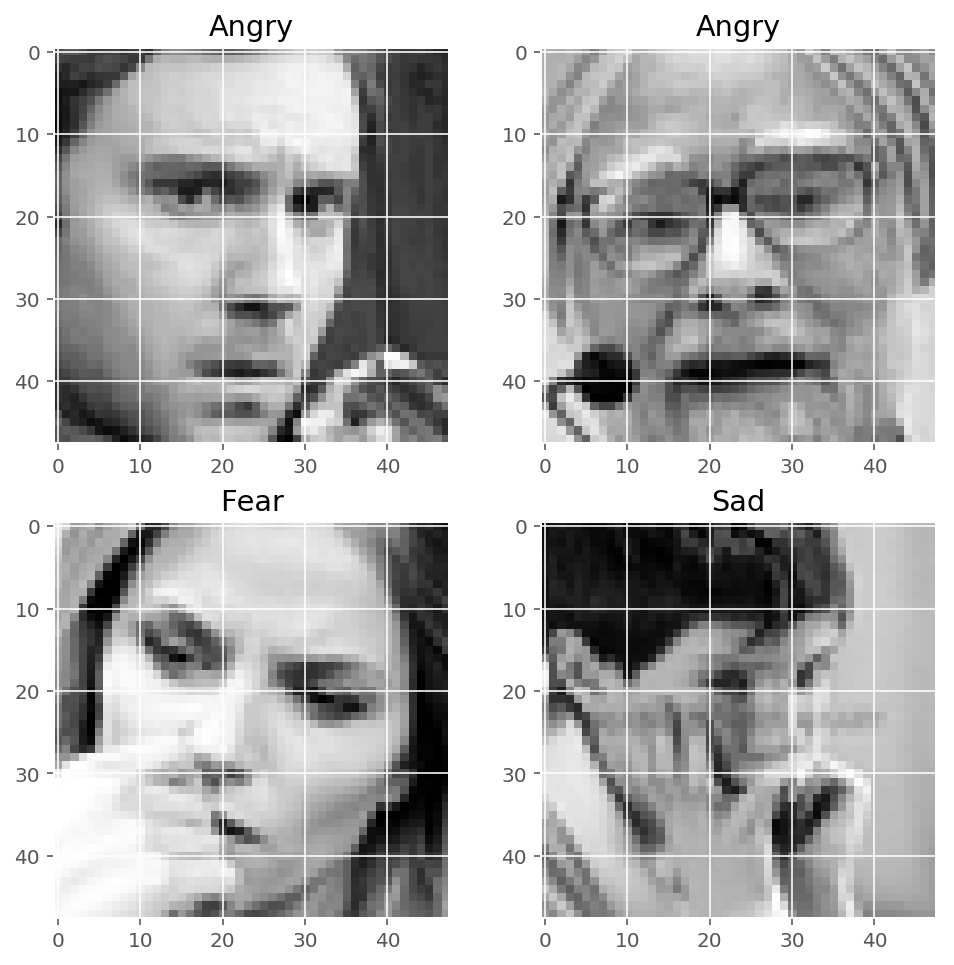

In [7]:
f, axarr = plt.subplots(2, 2, figsize=(8,8))
axarr[0, 0].imshow(train_x[0].reshape(48,48), cmap='gray', interpolation='nearest')
axarr[0, 0].set_title(emotion_idx2label[train_labels[0]])
axarr[0, 1].imshow(train_x[1].reshape(48,48), cmap='gray', interpolation='nearest')
axarr[0, 1].set_title(emotion_idx2label[train_labels[1]])
axarr[1, 0].imshow(train_x[2].reshape(48,48), cmap='gray', interpolation='nearest')
axarr[1, 0].set_title(emotion_idx2label[train_labels[2]])
axarr[1, 1].imshow(train_x[3].reshape(48,48), cmap='gray', interpolation='nearest')
axarr[1, 1].set_title(emotion_idx2label[train_labels[3]])

#### Looking for correlation 

In order for a model to *learn* there must exist some (direct or indirect) correlation between the inputs with their respective output i.e. there must be some pattern that exists for each of the facial expressions for the model to learn how to infer the associated emotion. 

Before tackling any machine learning task; it's worth spending sometime to search and come up with some theory of how to perform the prediction. This will inform you of the type of model you require. 

For example; to infer emotion from a image of a face we will make the hypothesis that some facial expression pattern exists for each emotion. We can check this by visualising the **mean** and **standard deviation** of all faces for each group. 

In [8]:
def show_mean_std_for_emotion(emotion_id):
    emotion_label = emotion_idx2label[emotion_id]
    
    emotion_train_x = train_x[np.array(train_labels) == emotion_id]
    
    emotion_mean = np.mean(emotion_train_x, axis=0)
    emotion_std = np.std(emotion_train_x, axis=0)
        
    f, axarr = plt.subplots(1, 2, figsize=(8,8))
    
    axarr[0].imshow(emotion_mean.reshape(48,48), 
                    cmap='gray', 
                    interpolation='nearest')
    axarr[0].set_title("Mean ({})".format(emotion_label))
    
    axarr[1].imshow(emotion_std.reshape(48,48), 
                    cmap='gray', 
                    interpolation='nearest')
    axarr[1].set_title("Std ({})".format(emotion_label))
    
    plt.show()

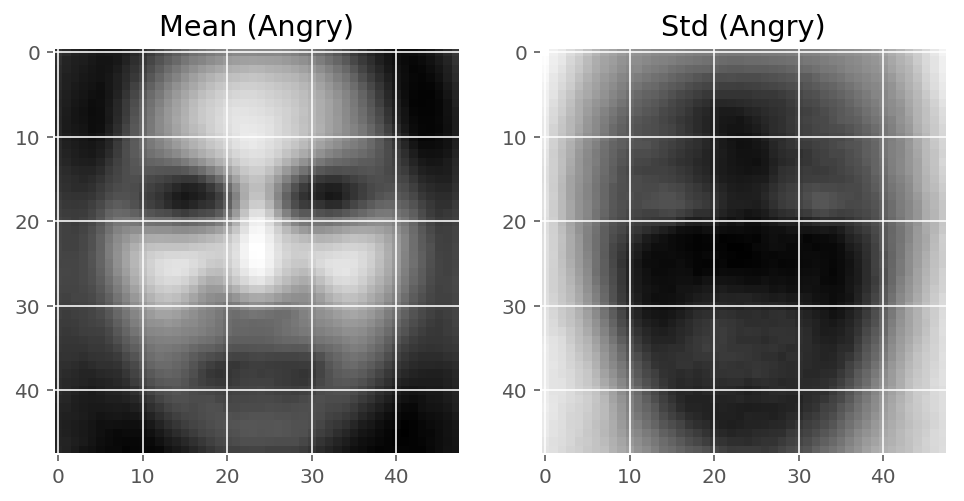

In [95]:
show_mean_std_for_emotion(0)

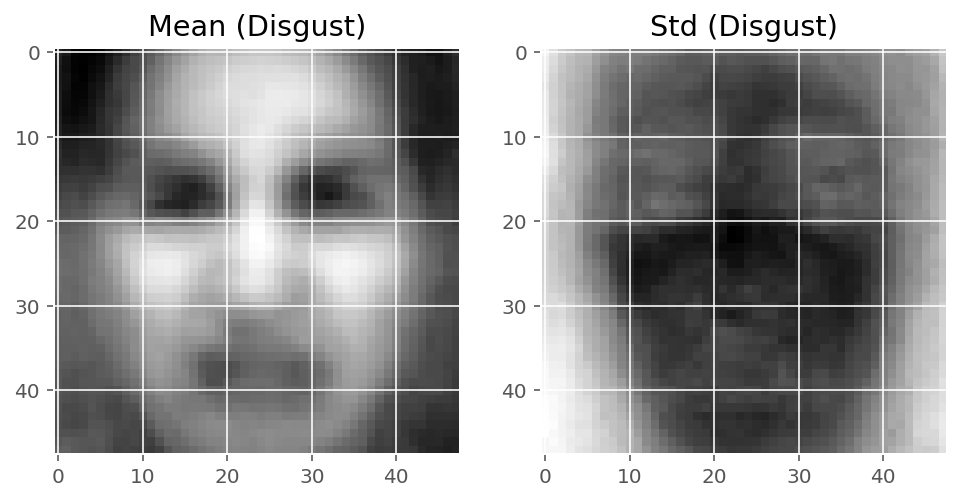

In [96]:
show_mean_std_for_emotion(1)

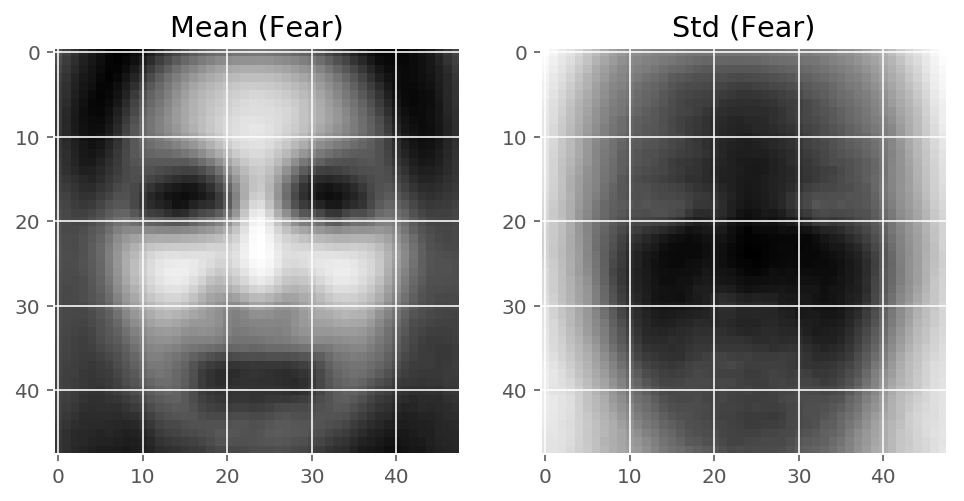

In [97]:
show_mean_std_for_emotion(2)

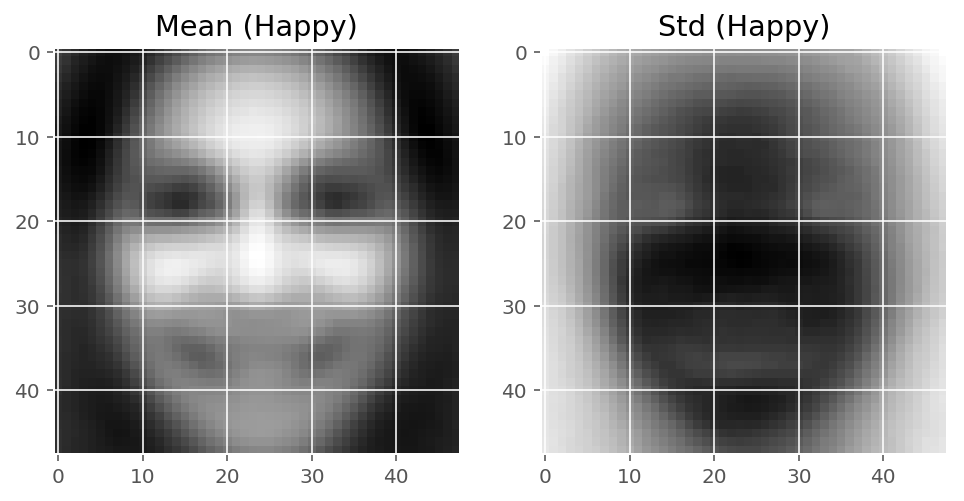

In [99]:
show_mean_std_for_emotion(3)

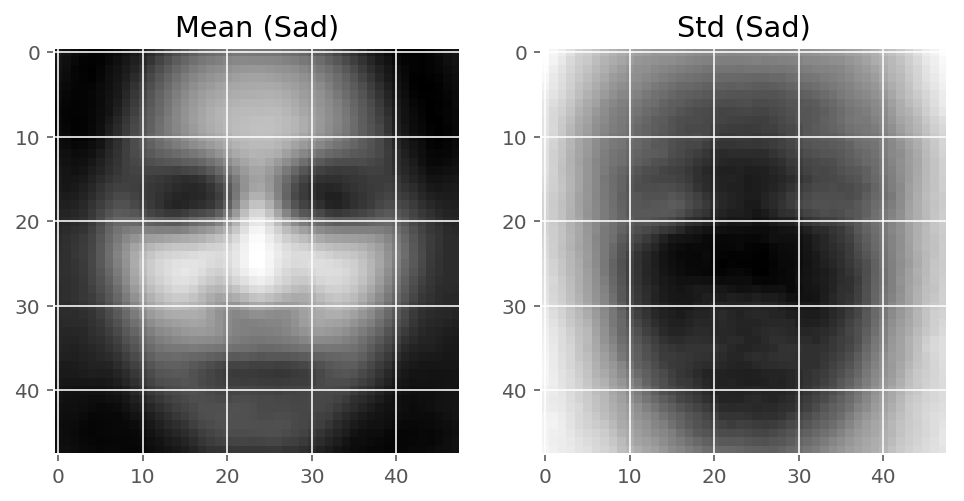

In [100]:
show_mean_std_for_emotion(4)

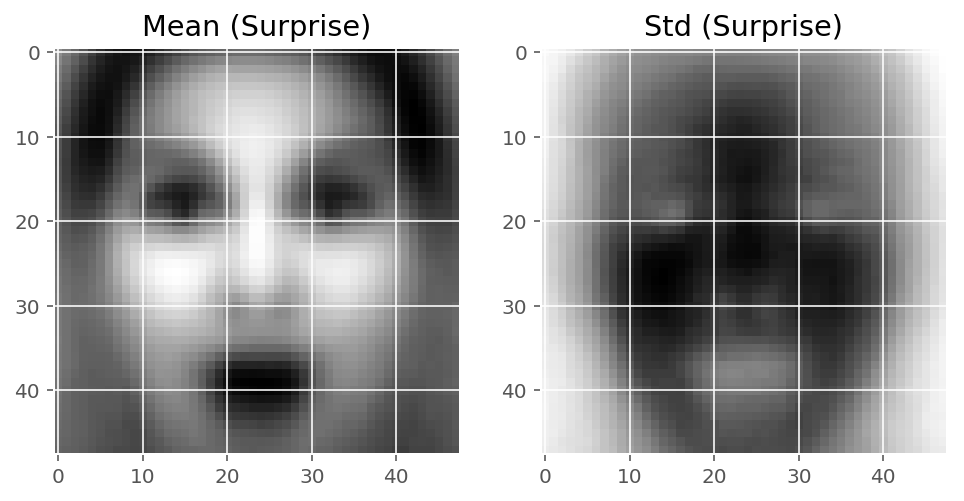

In [101]:
show_mean_std_for_emotion(5)

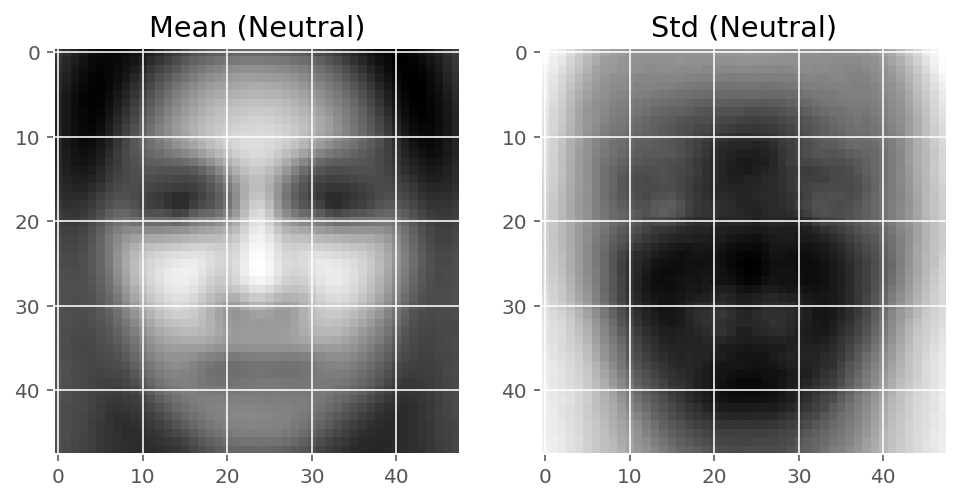

In [102]:
show_mean_std_for_emotion(6)

(Reminds me of a horror show); this exercise definitely highlights an existing pattern and you could probably tackle this problem sufficiently using k-nn or a fcn. 

Let's continue our exploration but now turning our attention to the labels (expected outputs). 

### Labels (Expected output) 

First we will inspect the range of values we have and their distribution. 

In [5]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6}

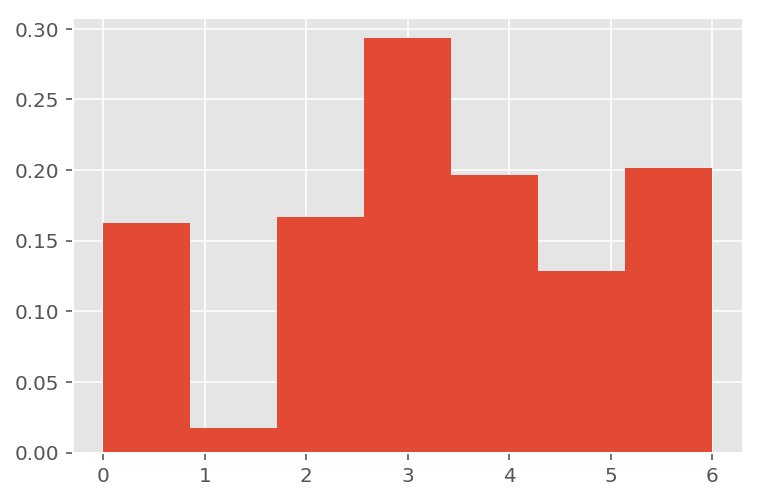

In [6]:
# histogram 
plt.hist([train_labels], bins=7, normed=True)
plt.show()

This highlights an imbalanced dataset - typically you would rectify this by either removing it our joining (in this case 1 - disgust) with another label, but here we will continue. 

## Data preparation

### Images

**Normalisation** aka rescale each pixel from the range 0-255 to 0.0-1.0. The reason for this is that it makes it *easier* for our model to train. Large values cause the model to *swing* while standardising your inputs (and typically intermediary layers using a BatchNorm) ensures that adjustment are don't have drastic effects causing the model to oscillate.  

In [7]:
train_x = train_x.astype('float32')/255.0
val_x = val_x.astype('float32')/255.0

print("Min: {}, Max: {}, Mean: {}, Std: {}".format(
    train_x.min(), 
    train_x.max(), 
    train_x.mean(), 
    train_x.std()))

Min: 0.0, Max: 1.0, Mean: 0.5077418684959412, Std: 0.25500908493995667


In [8]:
train_x = np.reshape(train_x, (-1, 48, 48, 1))
val_x = np.reshape(val_x, (-1, 48, 48, 1))

print("train_x shape {}, val_x shape {}".format(
    train_x.shape, 
    val_x.shape))

train_x shape (28709, 48, 48, 1), val_x shape (7178, 48, 48, 1)


### Labels

Because this is a classification problem, we will one-hot encode our labels. Two main reasons we do this are:
1. Labels have no ordinal value i.e. *happy* is not greater than *sad* 
2. We want a probability distribution across all labels 

So the following code is mostly concerned with encoding the labels. 

In [9]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6}

In [10]:
train_labels[:10]

[0, 0, 2, 4, 6, 2, 4, 3, 3, 2]

In [11]:
classes = len(set(train_labels))

In [12]:
train_y = [] 
for label in train_labels:
    encoded_label = [0] * classes
    encoded_label[label] = 1 
    train_y.append(encoded_label)
    
train_y = np.array(train_y, dtype='int')

In [13]:
for i in range(0, 6+1, 2):
    print("index:{}\t label:{}\t one-hot encoding: {}".format(
        i, 
        emotion_idx2label[np.argmax(train_y[i])], 
        train_y[i]))

index:0	 label:Angry	 one-hot encoding: [1 0 0 0 0 0 0]
index:2	 label:Fear	 one-hot encoding: [0 0 1 0 0 0 0]
index:4	 label:Neutral	 one-hot encoding: [0 0 0 0 0 0 1]
index:6	 label:Sad	 one-hot encoding: [0 0 0 0 1 0 0]


In [14]:
val_y = [] 
for label in val_labels:
    encoded_label = [0] * classes
    encoded_label[label] = 1 
    val_y.append(encoded_label)
    
val_y = np.array(val_y, dtype='int')

In [15]:
for i in range(0, 6+1, 2):
    print("index:{}\t label:{}\t one-hot encoding: {}".format(
        i, 
        emotion_idx2label[np.argmax(val_y[i])], 
        val_y[i]))

index:0	 label:Angry	 one-hot encoding: [1 0 0 0 0 0 0]
index:2	 label:Sad	 one-hot encoding: [0 0 0 0 1 0 0]
index:4	 label:Happy	 one-hot encoding: [0 0 0 1 0 0 0]
index:6	 label:Fear	 one-hot encoding: [0 0 1 0 0 0 0]


## Create model

In [2]:
import os 

from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks

from IPython.display import SVG

from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

In [3]:
def plot_accuracy_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [4]:
def create_model(input_shape=(48,48,1), classes=7, training=True):
    """
    
    """
    
    model = models.Sequential()
    model.add(layers.Conv2D(filters=64, 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu', 
                            input_shape=input_shape, 
                            name='layer_1_conv2d'))
    model.add(layers.MaxPool2D(pool_size=(2,2), 
                               strides=(2,2), 
                               name='layer_1_max'))
    
    # 24, 24, 64
    model.add(layers.Conv2D(filters=128, 
                            kernel_size=(3,3), 
                            activation='relu',
                            padding='same', 
                            name='layer_2_conv2d'))
    model.add(layers.MaxPool2D(pool_size=(2,2), 
                               strides=(2,2), 
                               name='layer_2_max'))
              
    # 12, 12, 128
    model.add(layers.Conv2D(filters=256, 
                            kernel_size=(3,3), 
                            activation='relu', 
                            padding='same', 
                            name='layer_3_conv2d')) 
    model.add(layers.MaxPool2D(pool_size=(2,2), 
                               strides=(2,2), 
                               name='layer_3_max'))
              
    # 6, 6, 256
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
        
    # 9216 (6 * 6 * 256) 
    model.add(layers.Dense(units=512, 
                           activation='relu', 
                           name='layer_4_dense'))
    # 512
    model.add(layers.Dense(units=128, 
                           activation='relu', 
                           name='layer_5_dense'))
    # 128
    model.add(layers.Dense(units=classes, 
                           activation='softmax', 
                           name='output'))
    # 7         
        
    return model 

In [34]:
def train(model, 
          train_x, train_y, val_x, val_y, 
          epochs=60, 
          batch_size=30, 
          validation_split=0.2, 
          load_previous_weights=False, 
          model_weights_file="data/fer2013_model_weights.h5"):
    
    if os.path.isfile(model_weights_file) and load_previous_weights:
        print("Loading weights from file {}".format(model_weights_file))
        model.load_weights(model_weights_file)
    
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizers.Adam(), 
        metrics=['acc'])
    
    checkpoint = callbacks.ModelCheckpoint(model_weights_file, 
                                           monitor='val_loss', 
                                           verbose=0, 
                                           save_best_only=True, 
                                           save_weights_only=True, 
                                           mode='auto', 
                                           period=10)
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    history = model.fit(train_x, train_y,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(val_x, val_y), 
                        callbacks=[early_stopping, checkpoint])       
    
    return history, model 

In [5]:
model = create_model() 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1_conv2d (Conv2D)      (None, 48, 48, 64)        640       
_________________________________________________________________
layer_1_max (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
layer_2_conv2d (Conv2D)      (None, 24, 24, 128)       73856     
_________________________________________________________________
layer_2_max (MaxPooling2D)   (None, 12, 12, 128)       0         
_________________________________________________________________
layer_3_conv2d (Conv2D)      (None, 12, 12, 256)       295168    
_________________________________________________________________
layer_3_max (MaxPooling2D)   (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
__________

In [36]:
#SVG(model_to_dot(model).create(prog='dot', format='svg'))
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [8]:
# Save architecture 
with open('output/fer2013_model_arc.json', 'w') as f:
    model_json = model.to_json()
    f.write(model_json)

In [37]:
history, model = train(model, 
                       train_x, train_y, 
                       val_x, val_y, 
                       model_weights_file="output/fer2013_model_weights.h5")

Train on 28709 samples, validate on 7178 samples
Epoch 1/60
28709/28709 [==============================] - 29s - loss: 1.7029 - acc: 0.3092 - val_loss: 1.4756 - val_acc: 0.4220
Epoch 2/60
28709/28709 [==============================] - 29s - loss: 1.4184 - acc: 0.4477 - val_loss: 1.3121 - val_acc: 0.4883
Epoch 3/60
28709/28709 [==============================] - 29s - loss: 1.2858 - acc: 0.5043 - val_loss: 1.2293 - val_acc: 0.5248
Epoch 4/60
28709/28709 [==============================] - 29s - loss: 1.1924 - acc: 0.5459 - val_loss: 1.1825 - val_acc: 0.5464
Epoch 5/60
28709/28709 [==============================] - 29s - loss: 1.1203 - acc: 0.5725 - val_loss: 1.1572 - val_acc: 0.5545
Epoch 6/60
28709/28709 [==============================] - 29s - loss: 1.0422 - acc: 0.6056 - val_loss: 1.1139 - val_acc: 0.5720
Epoch 7/60
28709/28709 [==============================] - 29s - loss: 0.9690 - acc: 0.6357 - val_loss: 1.1342 - val_acc: 0.5717
Epoch 8/60
28709/28709 [==============================]

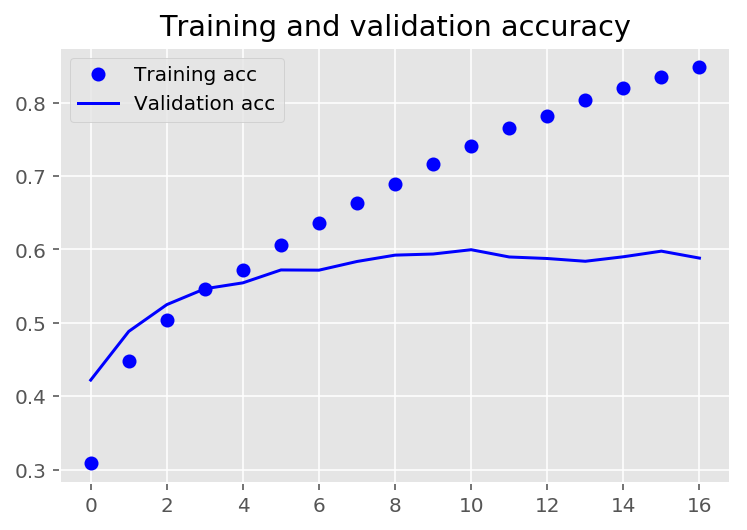

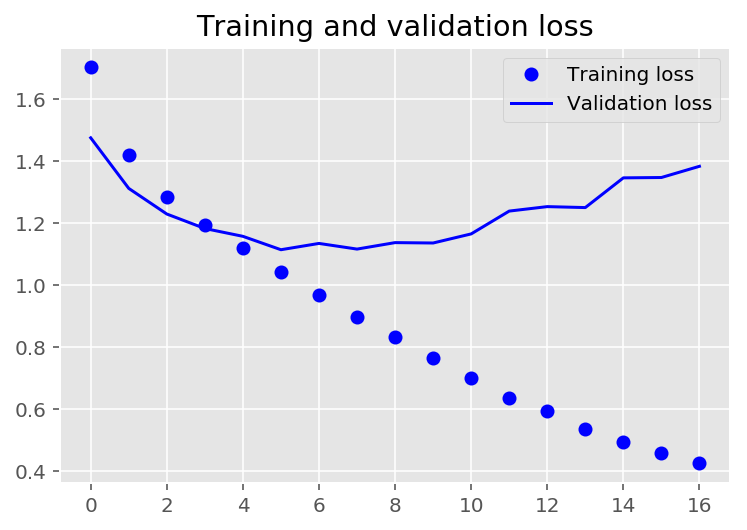

In [38]:
plot_accuracy_loss(history)

## Data Augmentation

Overfitting is often caused by having too few examples to learn from, resulting in the model not being able to generalise to new data due to the natural randomness in the real world. Data augmentation is an approach of generating more training examples by *augmenting* existing examples by random transformation. For example; rotating the image at varying degrees, flipping, etc. This helps expose the model to more examples to help it better generalise.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our **ImageDataGenerator** instance.

In [24]:
from keras import preprocessing
from keras.preprocessing import image

In [25]:
datagen = preprocessing.image.ImageDataGenerator(
    rotation_range=5, # value in degrees (0-180), a range within which to randomly rotate pictures
    width_shift_range=0.1, # ranges (as a fraction of total width) to randomly translate pictures 
    height_shift_range=0.1, # ranges (as a fraction of total height) to randomly translate pictures 
    shear_range=0.2, # randomly applying shearing transformations
    zoom_range=0.2, # randomly zooming inside pictures
    horizontal_flip=True, # randomly flipping half of the images horizontally
    fill_mode='nearest') # strategy used for filling in newly created pixels

In [26]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_x)

/usr/local/lib/python3.5/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28709, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


In [27]:
model = create_model() 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1_conv2d (Conv2D)      (None, 48, 48, 64)        640       
_________________________________________________________________
layer_1_max (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
layer_2_conv2d (Conv2D)      (None, 24, 24, 128)       73856     
_________________________________________________________________
layer_2_max (MaxPooling2D)   (None, 12, 12, 128)       0         
_________________________________________________________________
layer_3_conv2d (Conv2D)      (None, 12, 12, 256)       295168    
_________________________________________________________________
layer_3_max (MaxPooling2D)   (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
__________

In [28]:
def train(model, train_x, train_y, val_x, val_y, datagen, epochs=15, batch_size=64, validation_split=0.2,
          load_previous_weights=False,
          model_weights_file="data/fer2013_b_model_weights.h5"):
    
    if model_weights_file is not None and os.path.isfile(model_weights_file) and load_previous_weights:
        print("Loading weights from file {}".format(model_weights_file))
        model.load_weights(model_weights_file)
        
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizers.Adam(), 
        metrics=['acc'])
    
    checkpoint = callbacks.ModelCheckpoint(model_weights_file, 
                                           monitor='val_loss', 
                                           verbose=0, 
                                           save_best_only=True, 
                                           save_weights_only=True, 
                                           mode='auto', period=2)
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    history = model.fit_generator(datagen.flow(train_x, train_y, 
                                               batch_size=batch_size, 
                                               shuffle=True), 
                                  steps_per_epoch=int((train_x.shape[0] / batch_size) * 1.4), 
                                  epochs=epochs, 
                                  validation_data=(val_x, val_y), 
                                  callbacks=[checkpoint, early_stopping])        
    
    return history, model 

In [29]:
history, model = train(model, 
                       train_x, train_y, 
                       val_x, val_y, 
                       datagen, 
                       model_weights_file="output/fer2013_model_weights.h5")

Epoch 1/15
628/628 [==============================] - 32s - loss: 1.7274 - acc: 0.2980 - val_loss: 1.5492 - val_acc: 0.4037
Epoch 2/15
628/628 [==============================] - 31s - loss: 1.5615 - acc: 0.3890 - val_loss: 1.3901 - val_acc: 0.4709
Epoch 3/15
628/628 [==============================] - 31s - loss: 1.4434 - acc: 0.4415 - val_loss: 1.2636 - val_acc: 0.5177
Epoch 4/15
628/628 [==============================] - 31s - loss: 1.3802 - acc: 0.4720 - val_loss: 1.2210 - val_acc: 0.5297
Epoch 5/15
628/628 [==============================] - 31s - loss: 1.3213 - acc: 0.4888 - val_loss: 1.2036 - val_acc: 0.5318
Epoch 6/15
628/628 [==============================] - 31s - loss: 1.2850 - acc: 0.5103 - val_loss: 1.1455 - val_acc: 0.5596
Epoch 7/15
628/628 [==============================] - 31s - loss: 1.2652 - acc: 0.5169 - val_loss: 1.1441 - val_acc: 0.5548
Epoch 8/15
628/628 [==============================] - 31s - loss: 1.2411 - acc: 0.5290 - val_loss: 1.1215 - val_acc: 0.5652
Epoch 9/

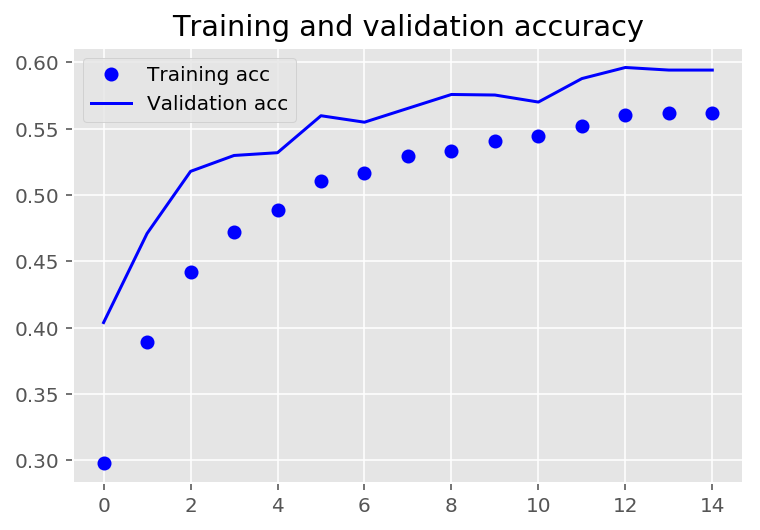

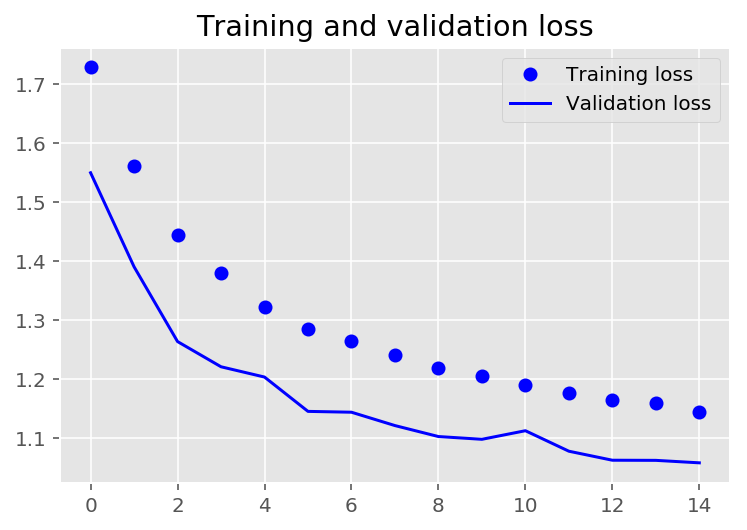

In [30]:
    plot_accuracy_loss(history)

## Visualizing intermediate activations

In [19]:
model = create_model() 
model.load_weights("output/fer2013_model_weights.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1_conv2d (Conv2D)      (None, 48, 48, 64)        640       
_________________________________________________________________
layer_1_max (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
layer_2_conv2d (Conv2D)      (None, 24, 24, 128)       73856     
_________________________________________________________________
layer_2_max (MaxPooling2D)   (None, 12, 12, 128)       0         
_________________________________________________________________
layer_3_conv2d (Conv2D)      (None, 12, 12, 256)       295168    
_________________________________________________________________
layer_3_max (MaxPooling2D)   (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
__________

Load a image we can use as our input to inspect visualise the intermediate activations -- this should **not** be part of the images the network was trained on. 

In [ ]:
random.seed(90)

In [73]:
happy_indicies = [idx for idx 
                  in range(0,len(val_x)) 
                  if emotion_idx2label[val_labels[idx]] == 'Happy']

In [167]:
happy_viz_idx = happy_indicies[random.randint(0, len(happy_indicies))]
print("happy_viz_idx {}".format(happy_viz_idx))

happy_viz_idx 3981


Happy


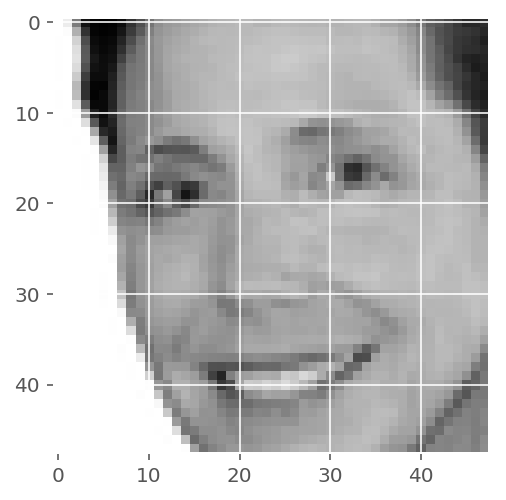

In [108]:
happy_viz_x = val_x[happy_viz_idx]  

plt.imshow(happy_viz_x.reshape(48,48), cmap='gray', interpolation='nearest')
print(emotion_idx2label[val_labels[happy_viz_idx]])

In [110]:
old_shape = happy_viz_x.shape
happy_viz_x = happy_viz_x.reshape(1, happy_viz_x.shape[0], happy_viz_x.shape[1], happy_viz_x.shape[2])
print("from shape {} to {}".format(old_shape, happy_viz_x.shape))

from shape (48, 48, 1) to (1, 48, 48, 1)


To extract the feature maps we want to look at, we will create a Keras model that takes a image as input and outputs the activations of all convolution and pooling layers. 
We will use the Keras class Model which take, unlike the Sequential model, allows the model to have multiple inputs and outputs (with the former being desirable here). 

In [111]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output 
                 for layer 
                 in model.layers 
                 if "_conv2d" in layer.name 
                     or "_max" in layer.name]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [112]:
activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1_conv2d_input (InputL (None, 48, 48, 1)         0         
_________________________________________________________________
layer_1_conv2d (Conv2D)      (None, 48, 48, 64)        640       
_________________________________________________________________
layer_1_max (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
layer_2_conv2d (Conv2D)      (None, 24, 24, 128)       73856     
_________________________________________________________________
layer_2_max (MaxPooling2D)   (None, 12, 12, 128)       0         
_________________________________________________________________
layer_3_conv2d (Conv2D)      (None, 12, 12, 256)       295168    
_________________________________________________________________
layer_3_max (MaxPooling2D)   (None, 6, 6, 256)         0         
Total para

We will feed our **activation_model** the input from above (*viz_x*) and access the exposed activation layers from the original model (6 in this case). 

In [113]:
# This will return a list of 6 numpy arrays; one array per layer activation
happy_activations = activation_model.predict(happy_viz_x)

In [114]:
# inspect the first output layer 
print(happy_activations[0].shape)

(1, 48, 48, 64)


It's a 48x48 feature map with 64 channels; let's visualizing the first channel

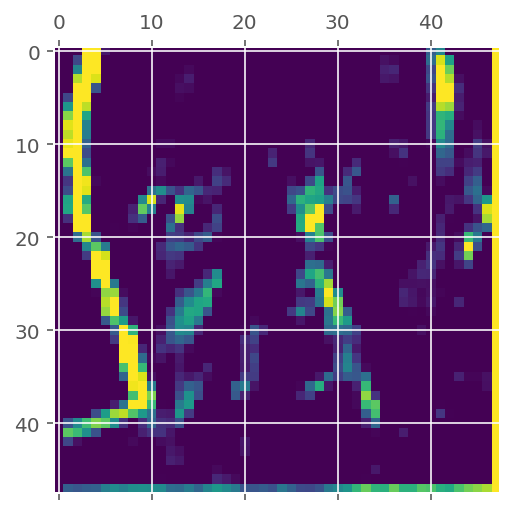

In [201]:
activation_img = happy_activations[0][0, :, :, 0]
activation_img -= activation_img.mean()
activation_img /= activation_img.std()
activation_img *= 64
activation_img += 128
activation_img = np.clip(activation_img, 0, 255).astype('uint8')
plt.matshow(activation_img, cmap='viridis')
plt.show()

This channel appears to encode a vertical edge detector.

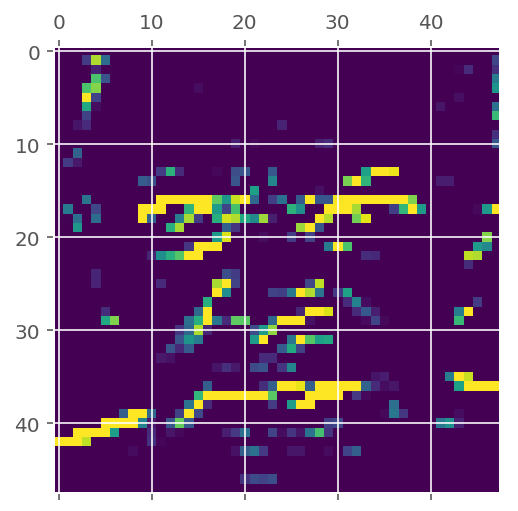

In [208]:
activation_img = happy_activations[0][0, :, :, 2]
activation_img -= activation_img.mean()
activation_img /= activation_img.std()
activation_img *= 64
activation_img += 128
activation_img = np.clip(activation_img, 0, 255).astype('uint8')
plt.matshow(activation_img, cmap='viridis')
plt.show()

This channel appears to encode a horizontal edge detector.

Let's no plot a complete visualization of all the activations in the network. 

In [159]:
def display_activations(activations, activation_model):
    layer_names = []
    for layer in activation_model.layers[1:]:
        layer_names.append(layer.name)

    images_per_row = 16

    # Iterate through each layer and display the associated feature maps
    for layer_name, layer_activation in zip(layer_names, activations):
        # Obtain the number of features in the feature map 
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # Tile each filter into a horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_idx = col * images_per_row + row
                channel_image = layer_activation[0,:,:,channel_idx]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()

/Users/jnewnham/anaconda/envs/trondheimdc/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


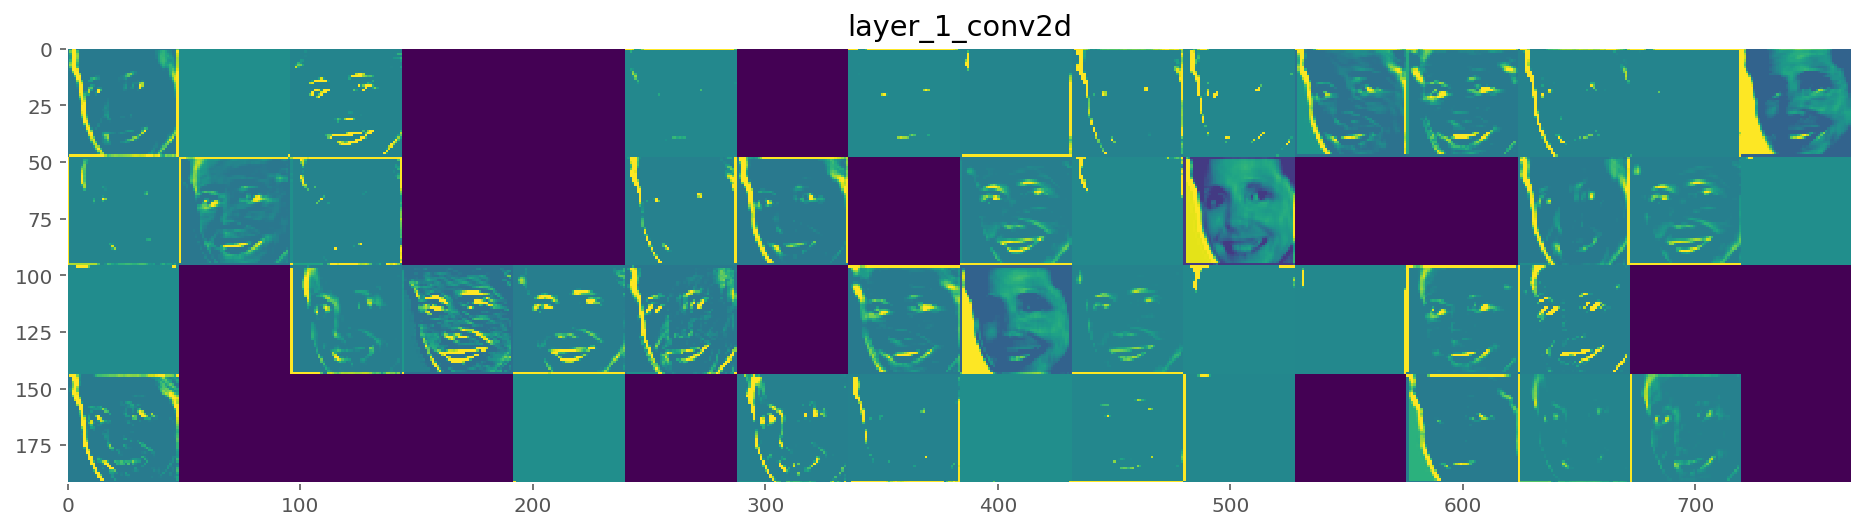

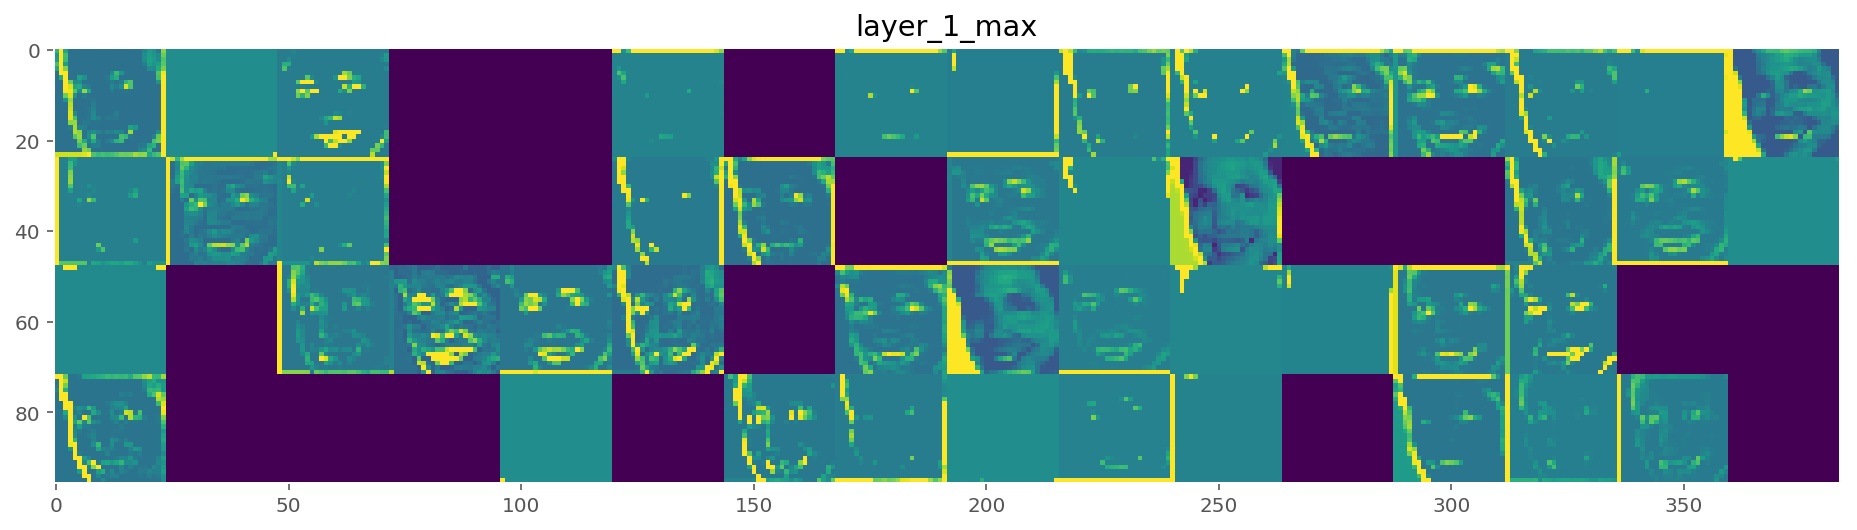

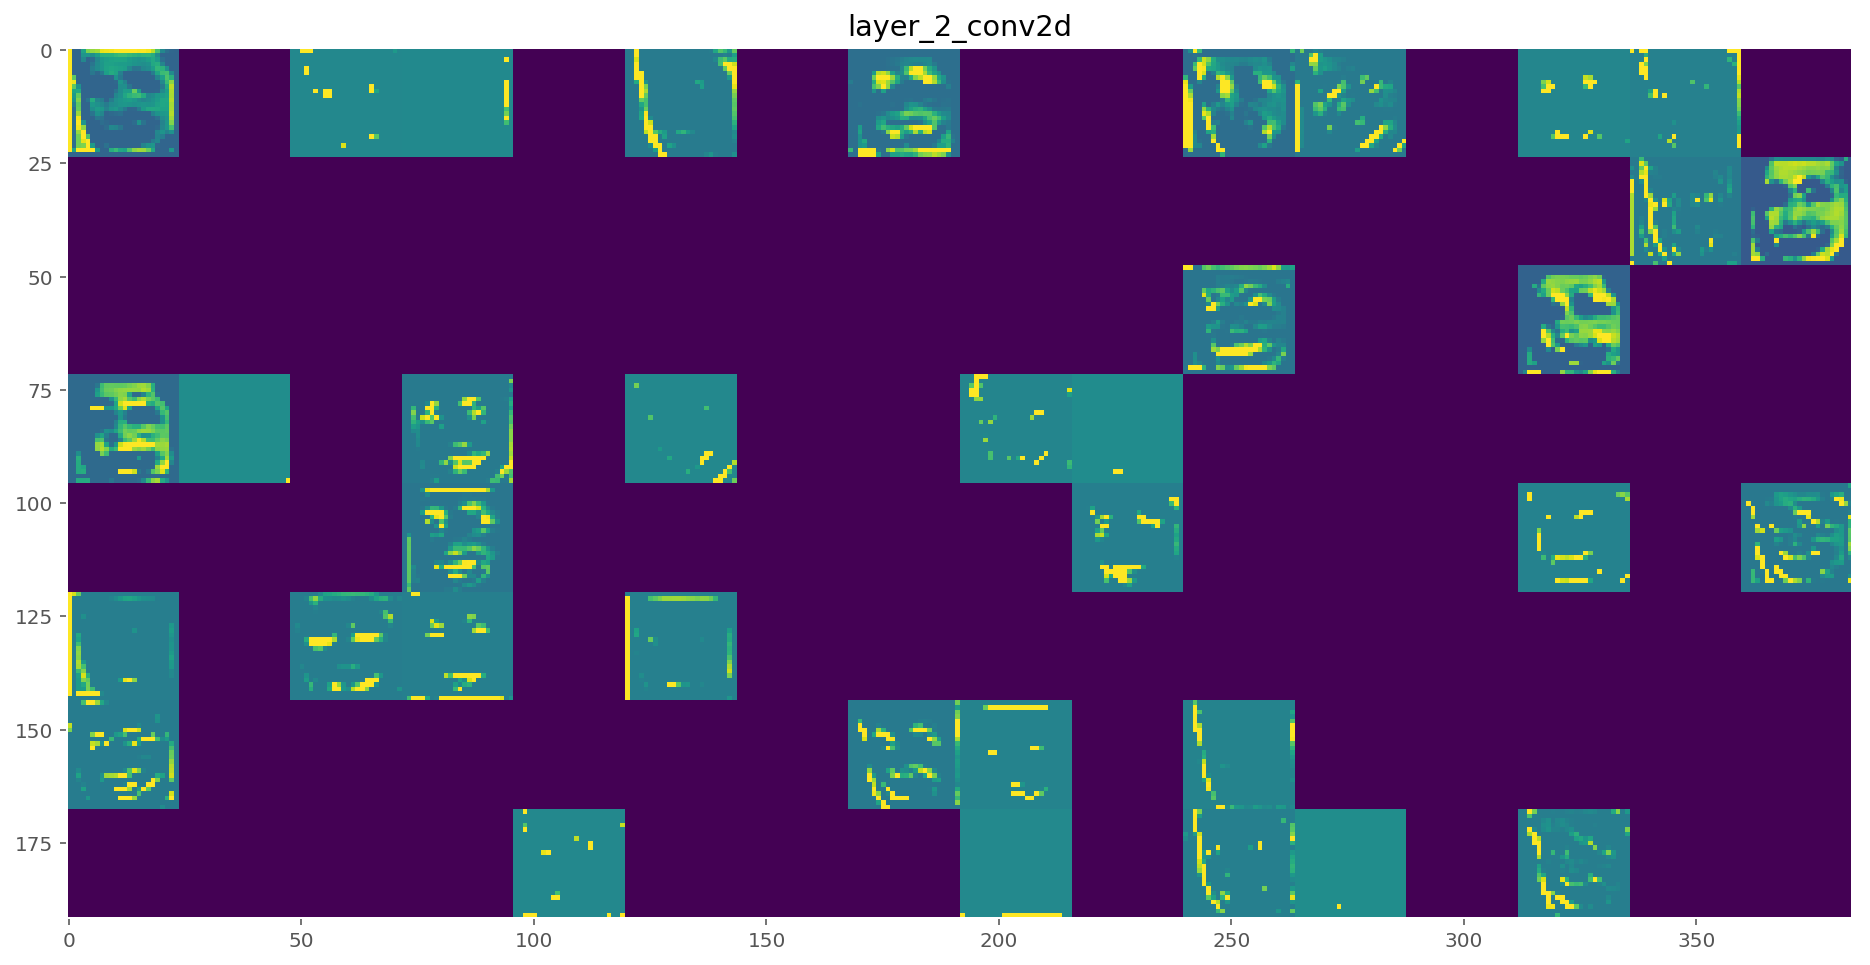

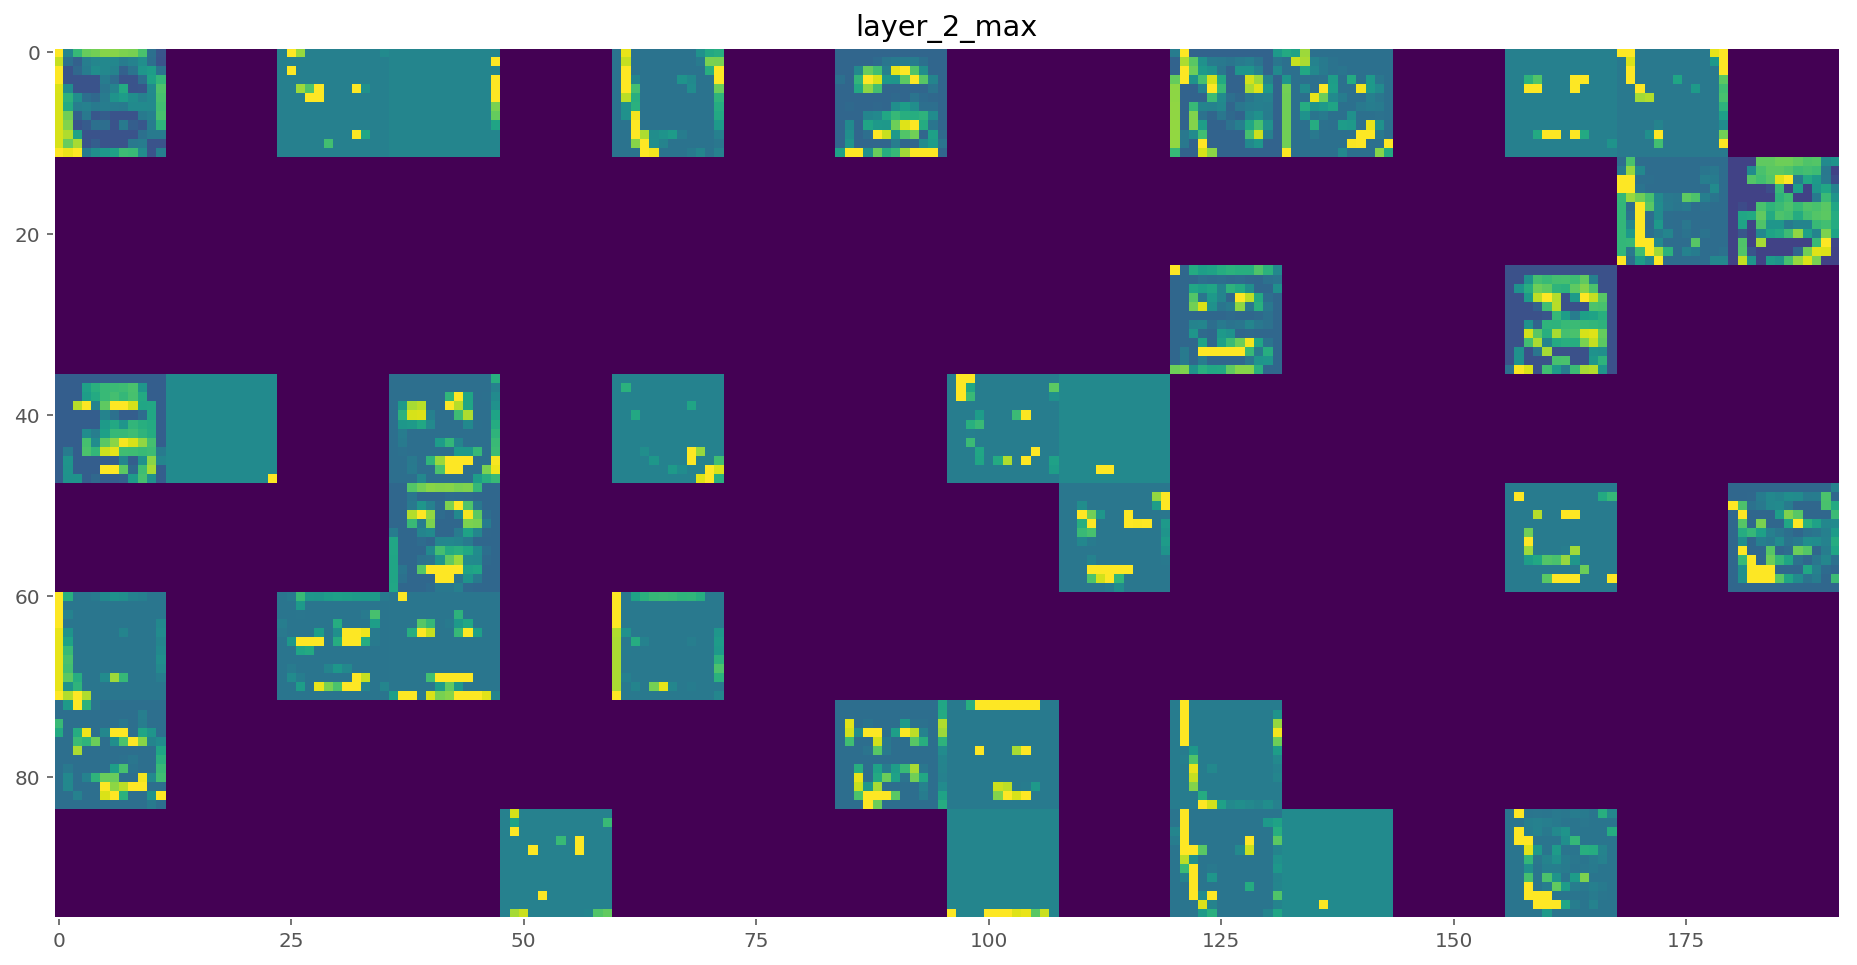

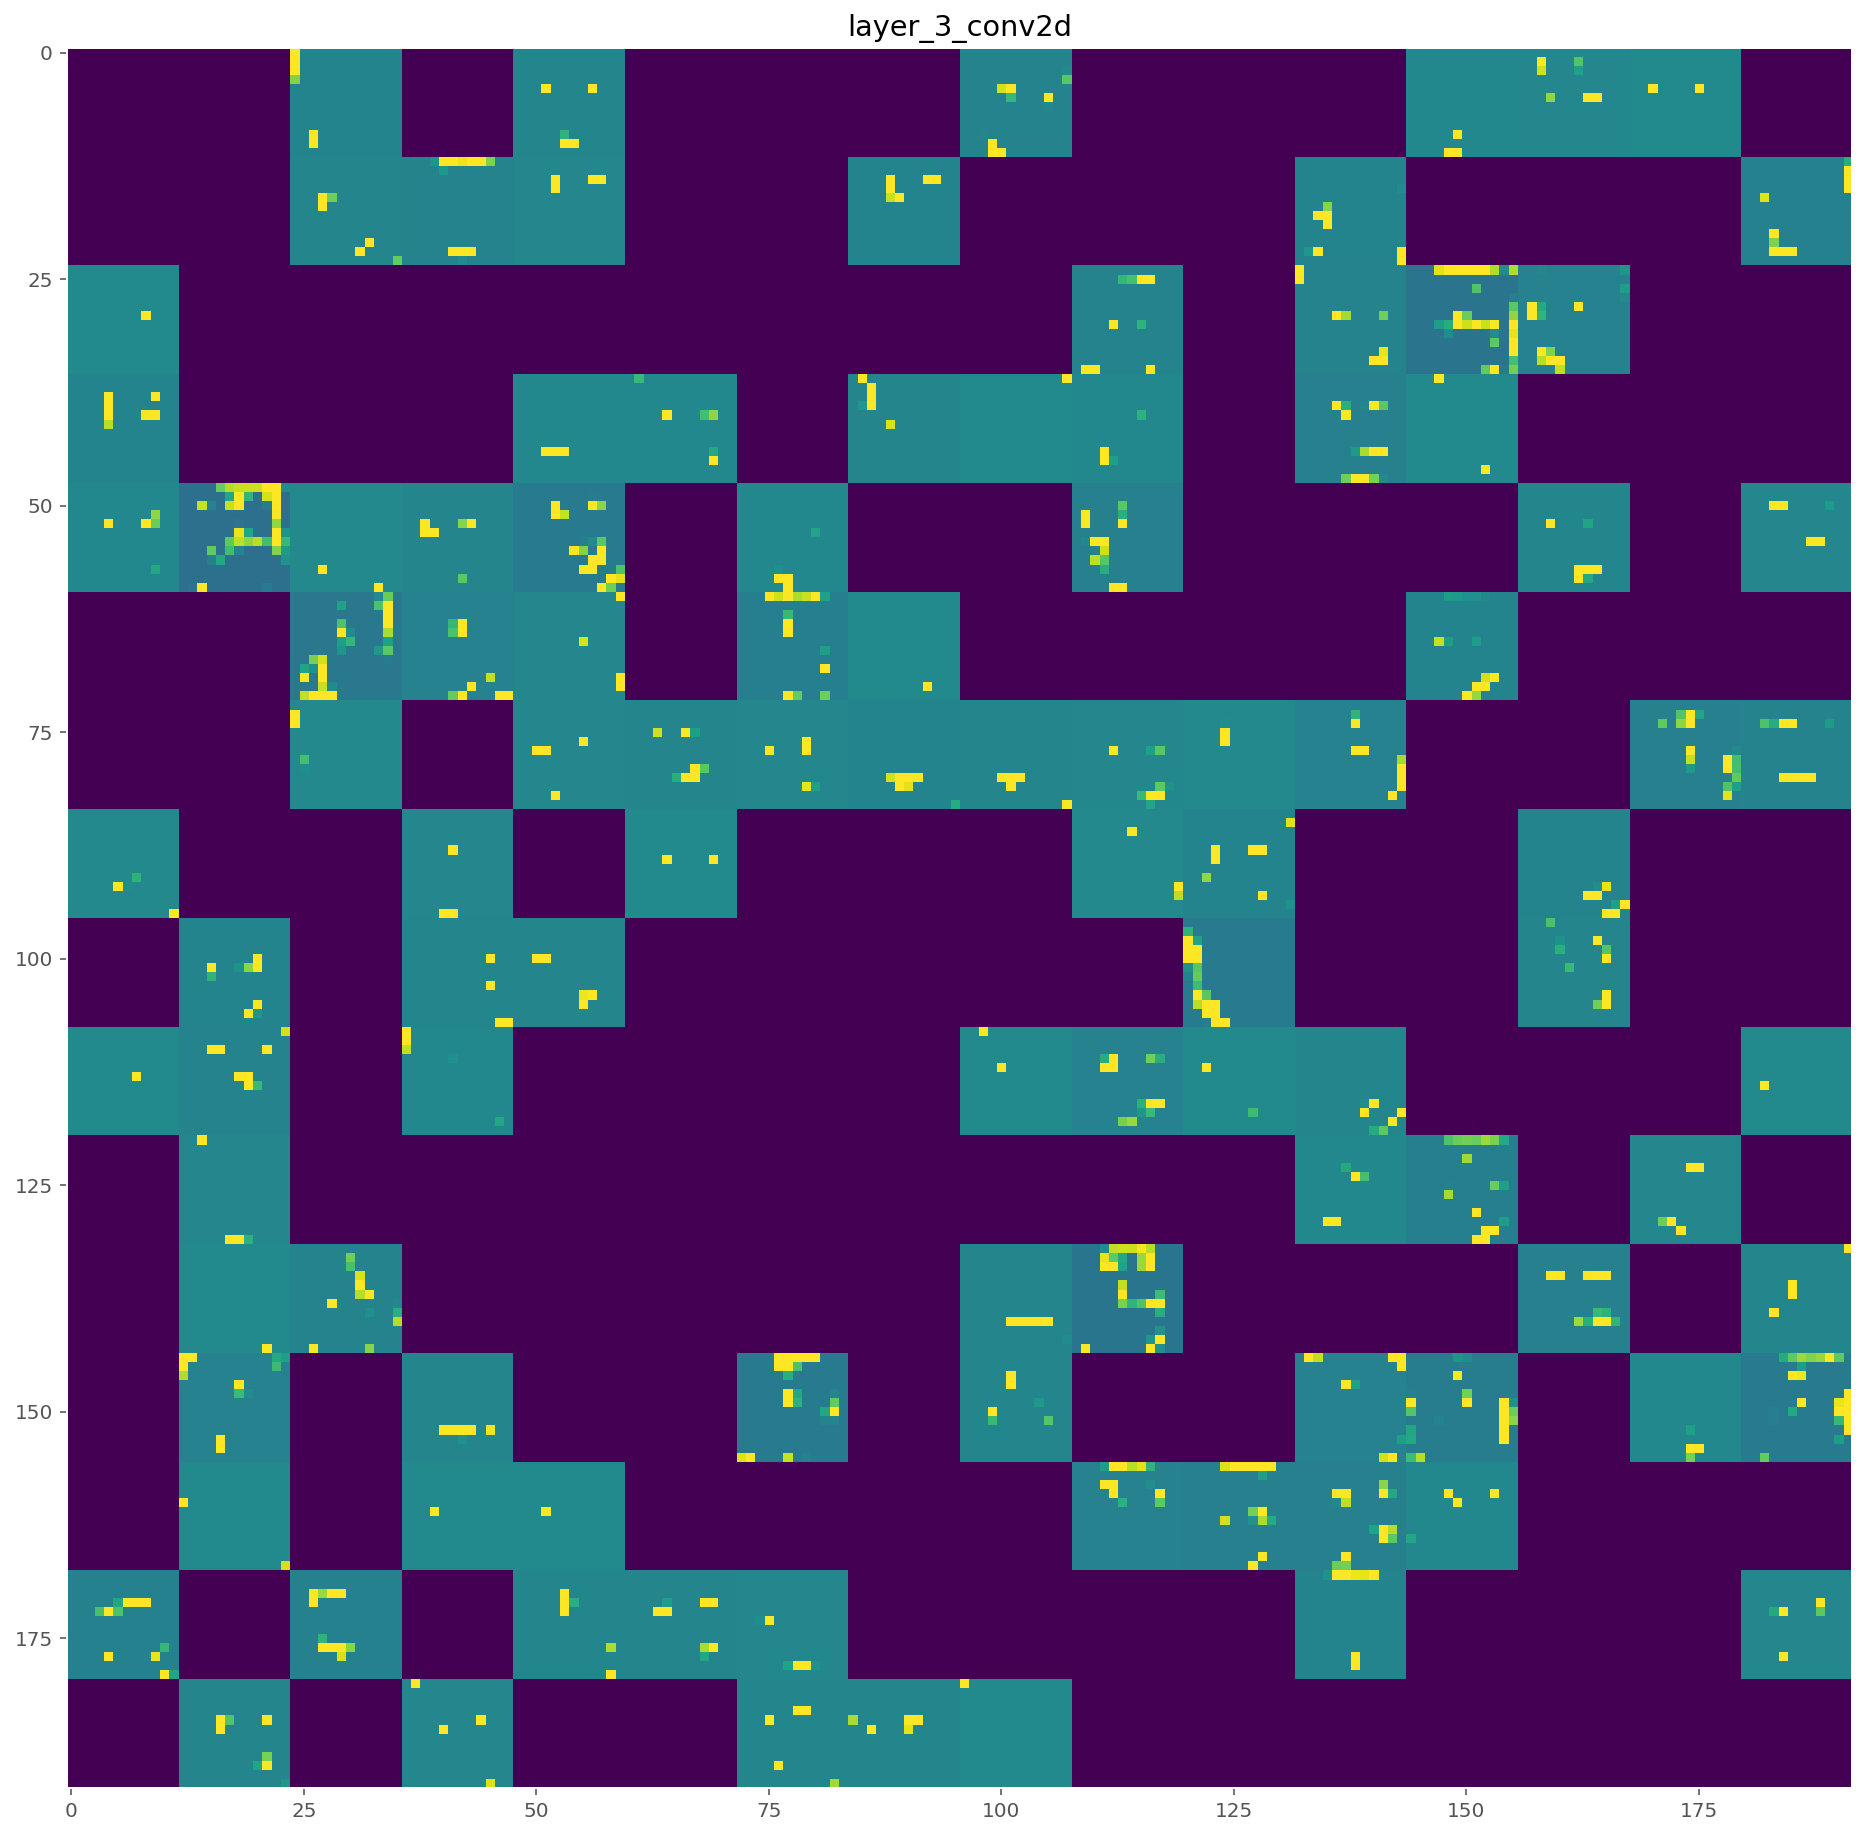

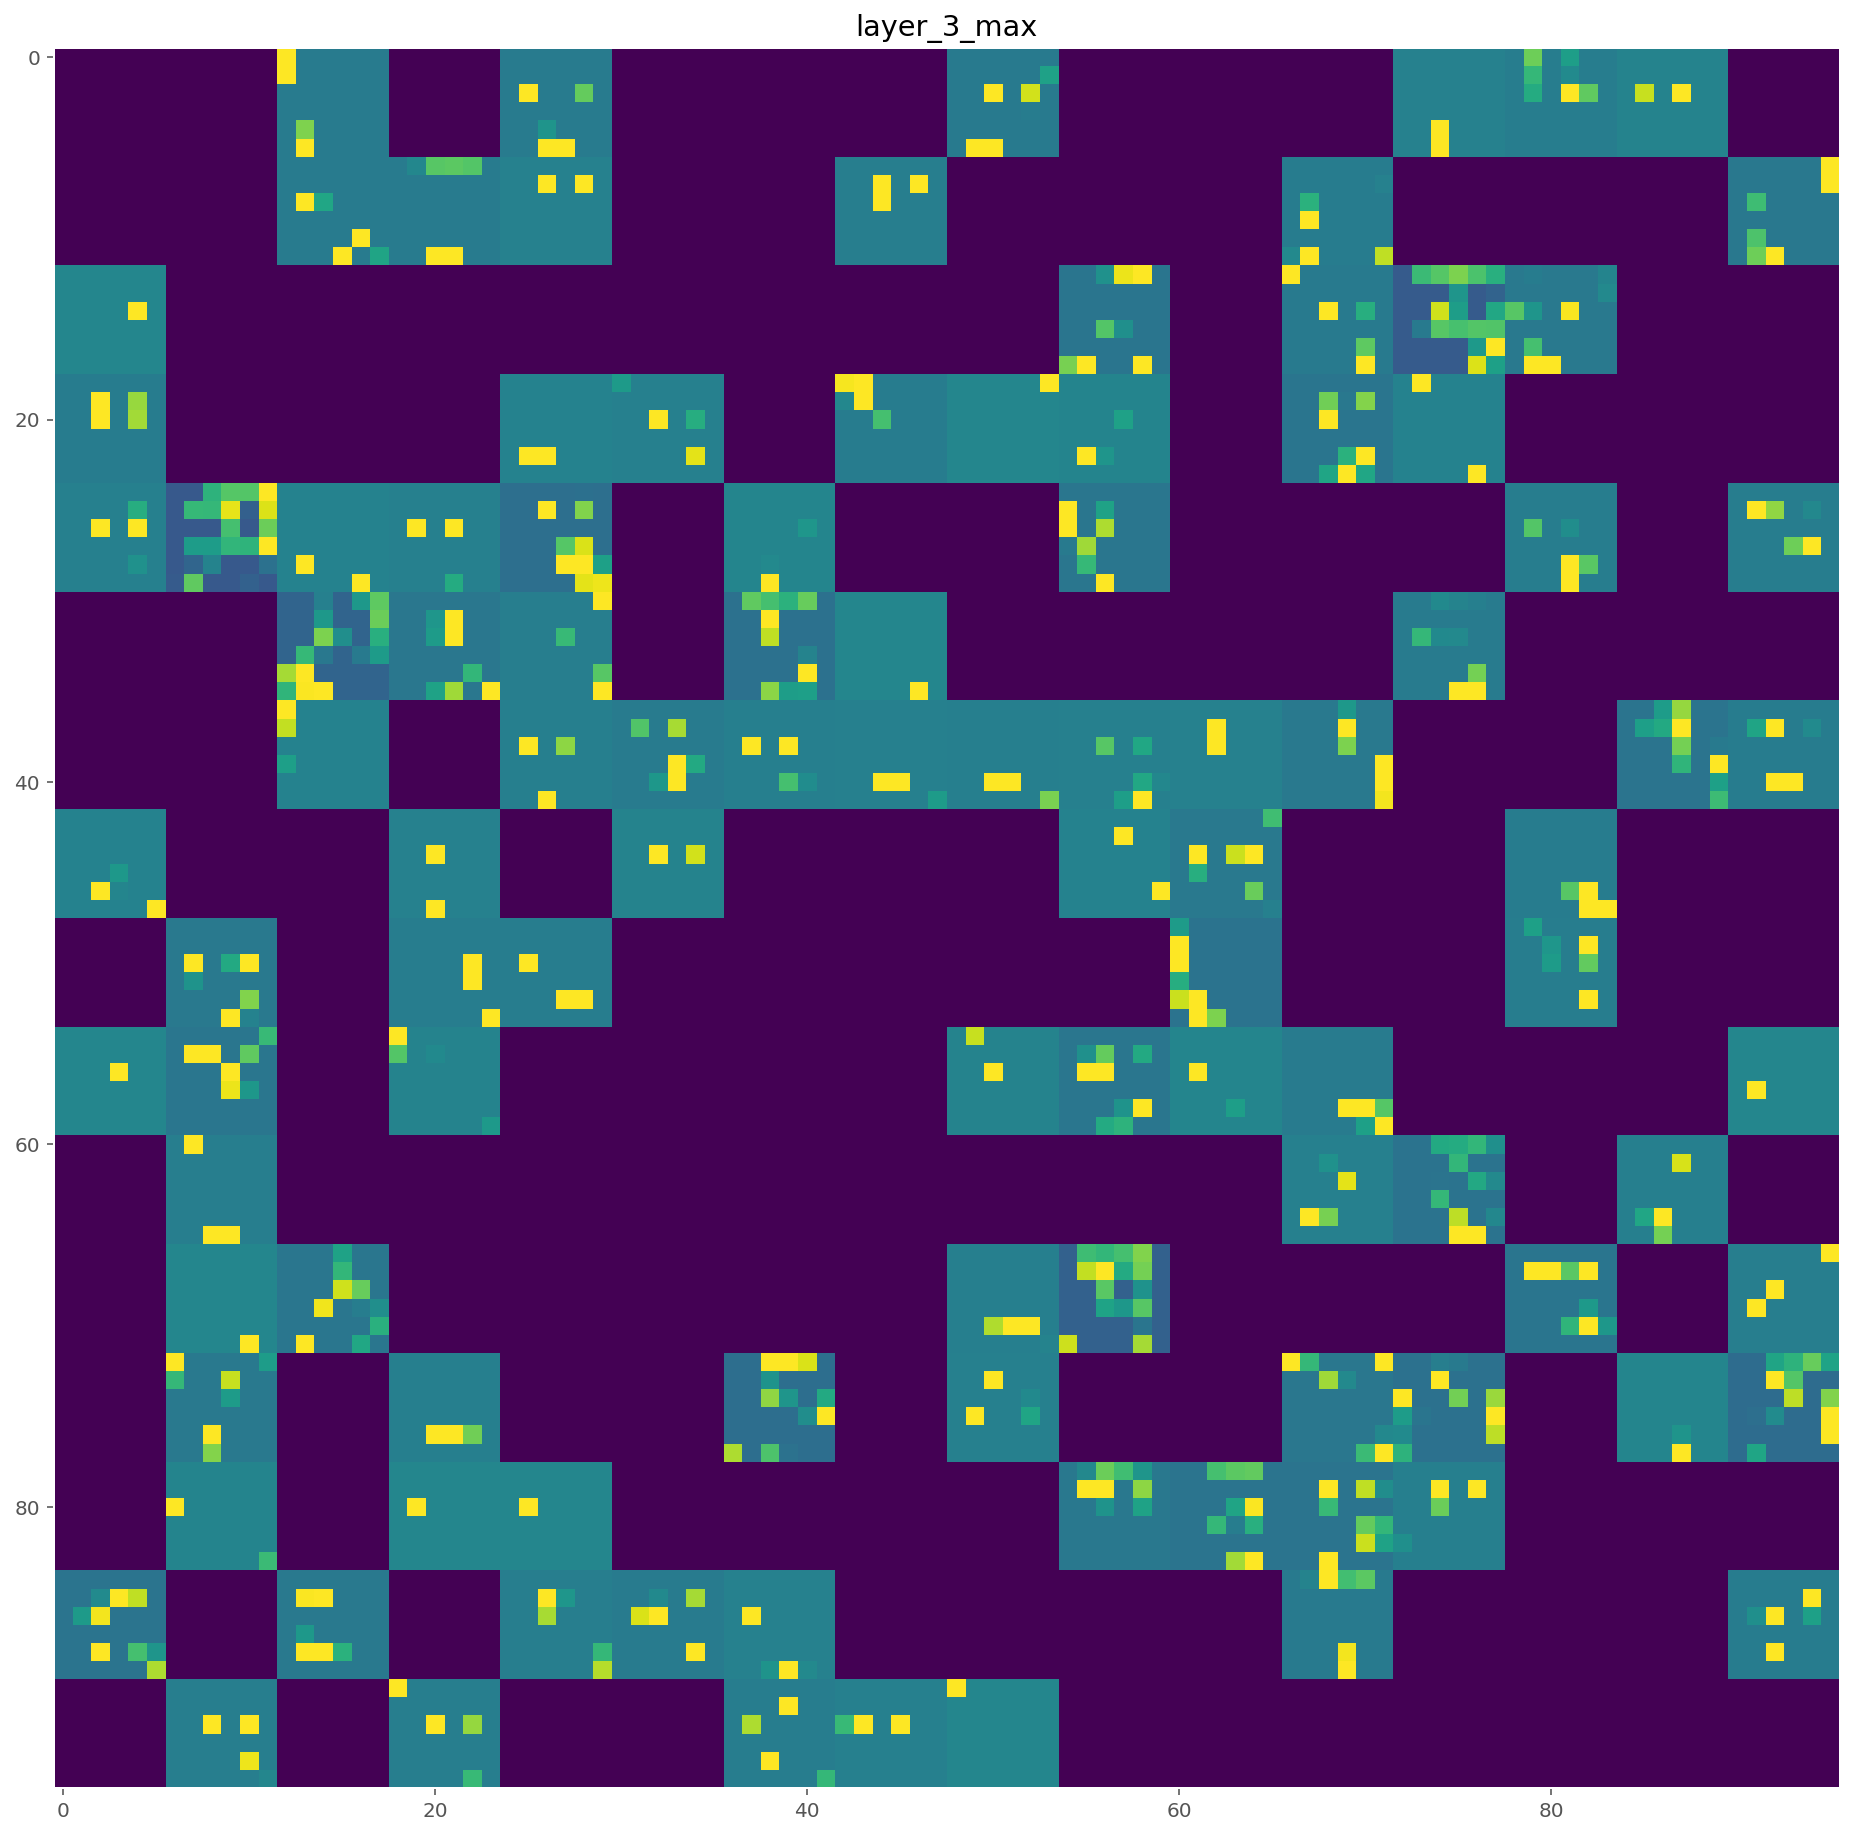

In [160]:
display_activations(happy_activations, activation_model)

A few remarkable things to note here:
- The first layer acts as a collection of edge detectors with the convolutions retaining much of the information of the input.
- Going deeper into the network the features are becoming more abstract and less visually interpretable. Increasingly less information related to the visual information of the image is propagated up and has been replaced with increasingly more information about the class (emotion). 
- You will notice the increasing sparsity of the activiations increases with respect to the depth of the layer; this signifies that a pattern encoded by the filter isn't found in the input image.

Let's now look at an **Angry** face

In [175]:
angry_indicies = [idx for idx in range(0,len(val_x)) if emotion_idx2label[val_labels[idx]] == 'Angry']

In [192]:
angry_viz_idx = angry_indicies[random.randint(0, len(angry_indicies))]
print("angry_viz_idx {}".format(angry_viz_idx))

angry_viz_idx 6898


Angry


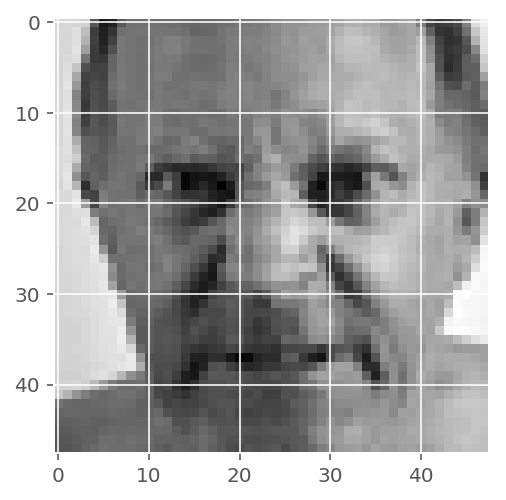

In [193]:
angry_viz_x = val_x[angry_viz_idx]  

plt.imshow(angry_viz_x.reshape(48,48), cmap='gray', interpolation='nearest')
print(emotion_idx2label[val_labels[angry_viz_idx]])

In [194]:
angry_viz_x = angry_viz_x.reshape(1, angry_viz_x.shape[0], angry_viz_x.shape[1], angry_viz_x.shape[2])

In [196]:
angry_activations = activation_model.predict(angry_viz_x)

/Users/jnewnham/anaconda/envs/trondheimdc/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


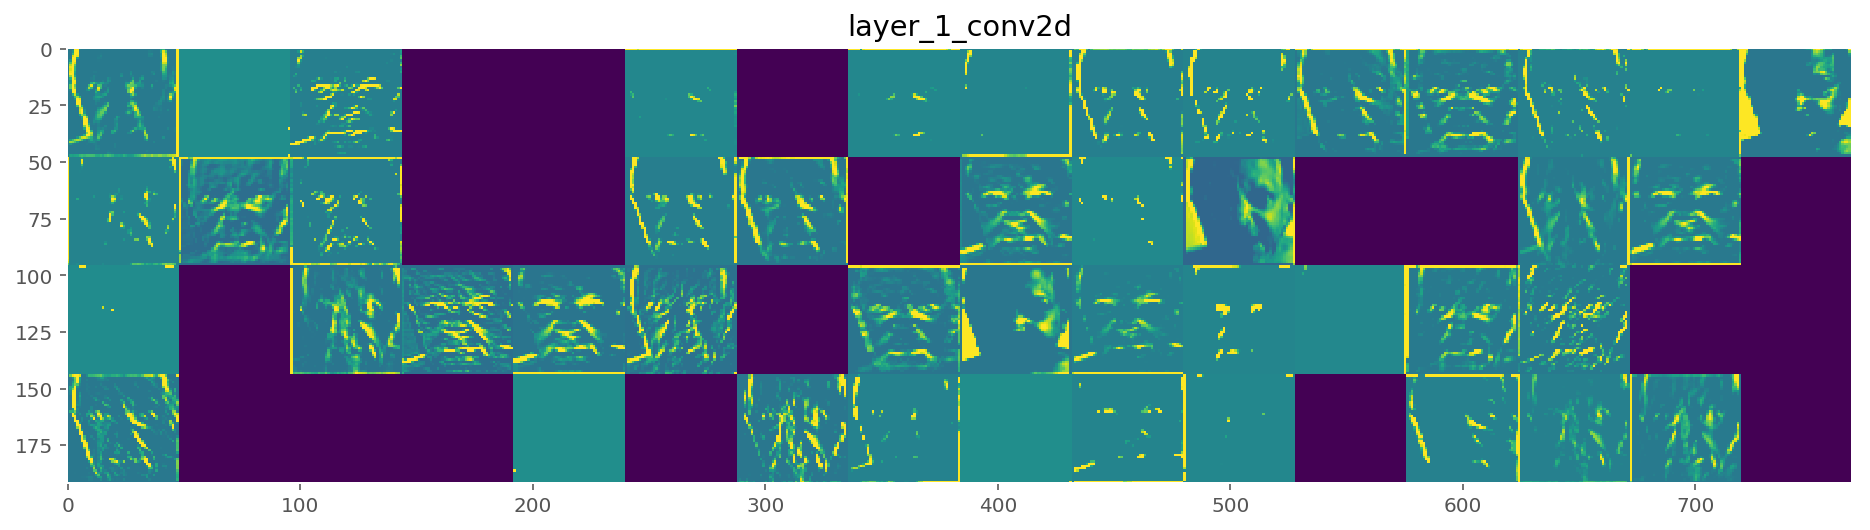

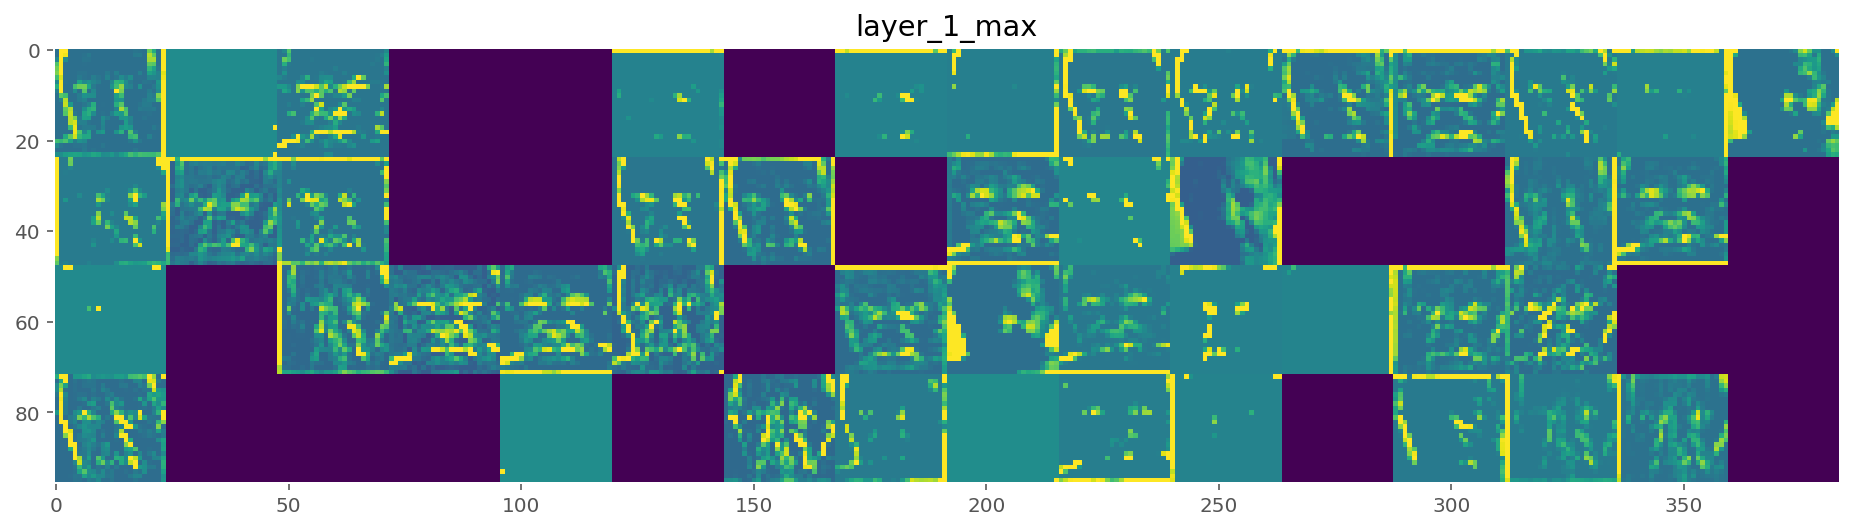

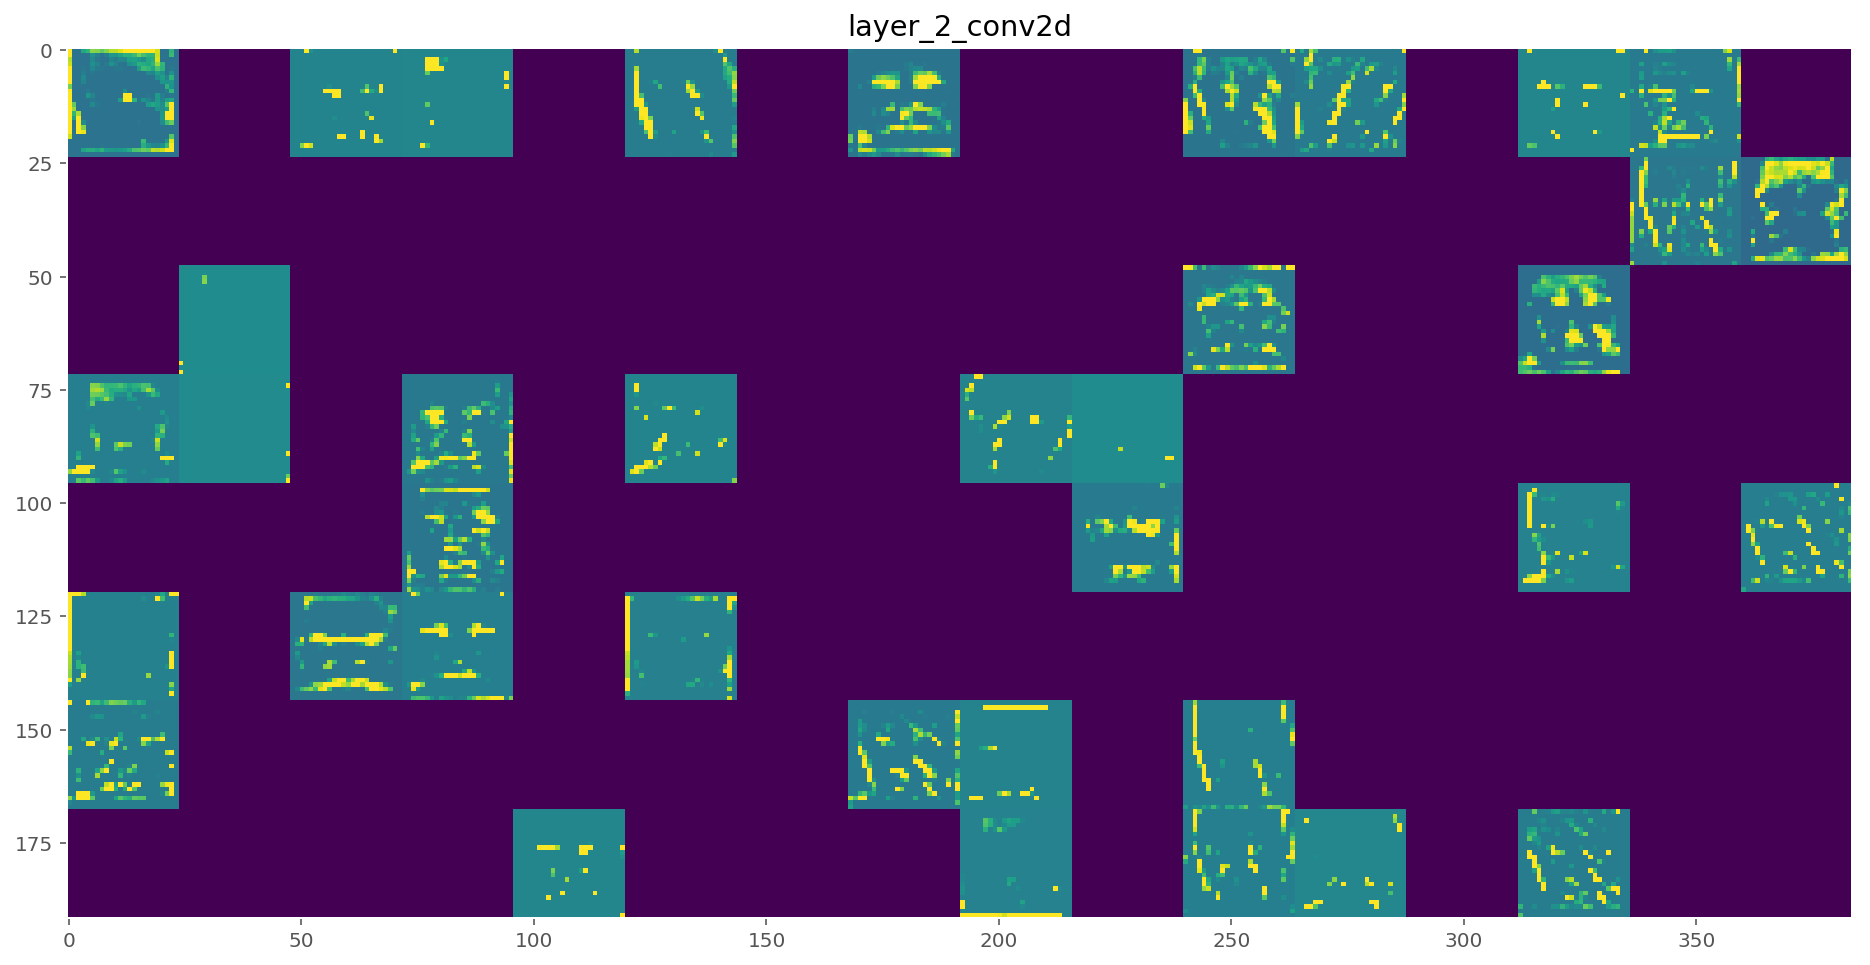

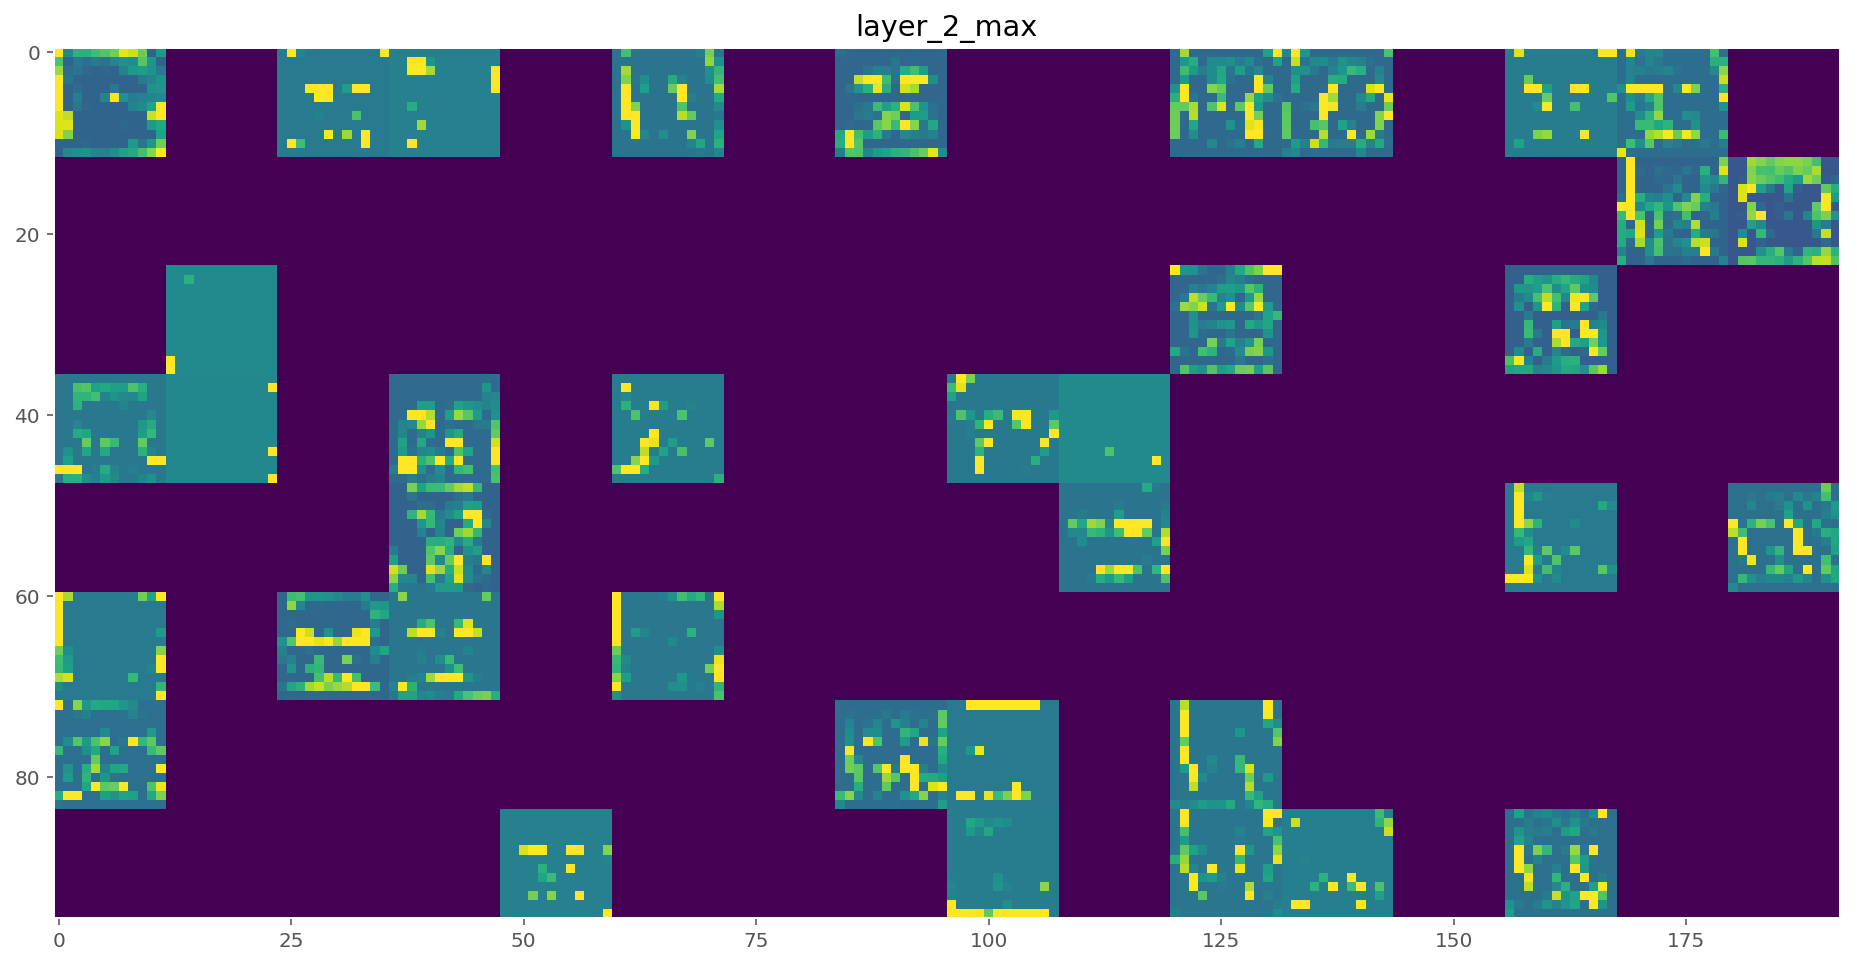

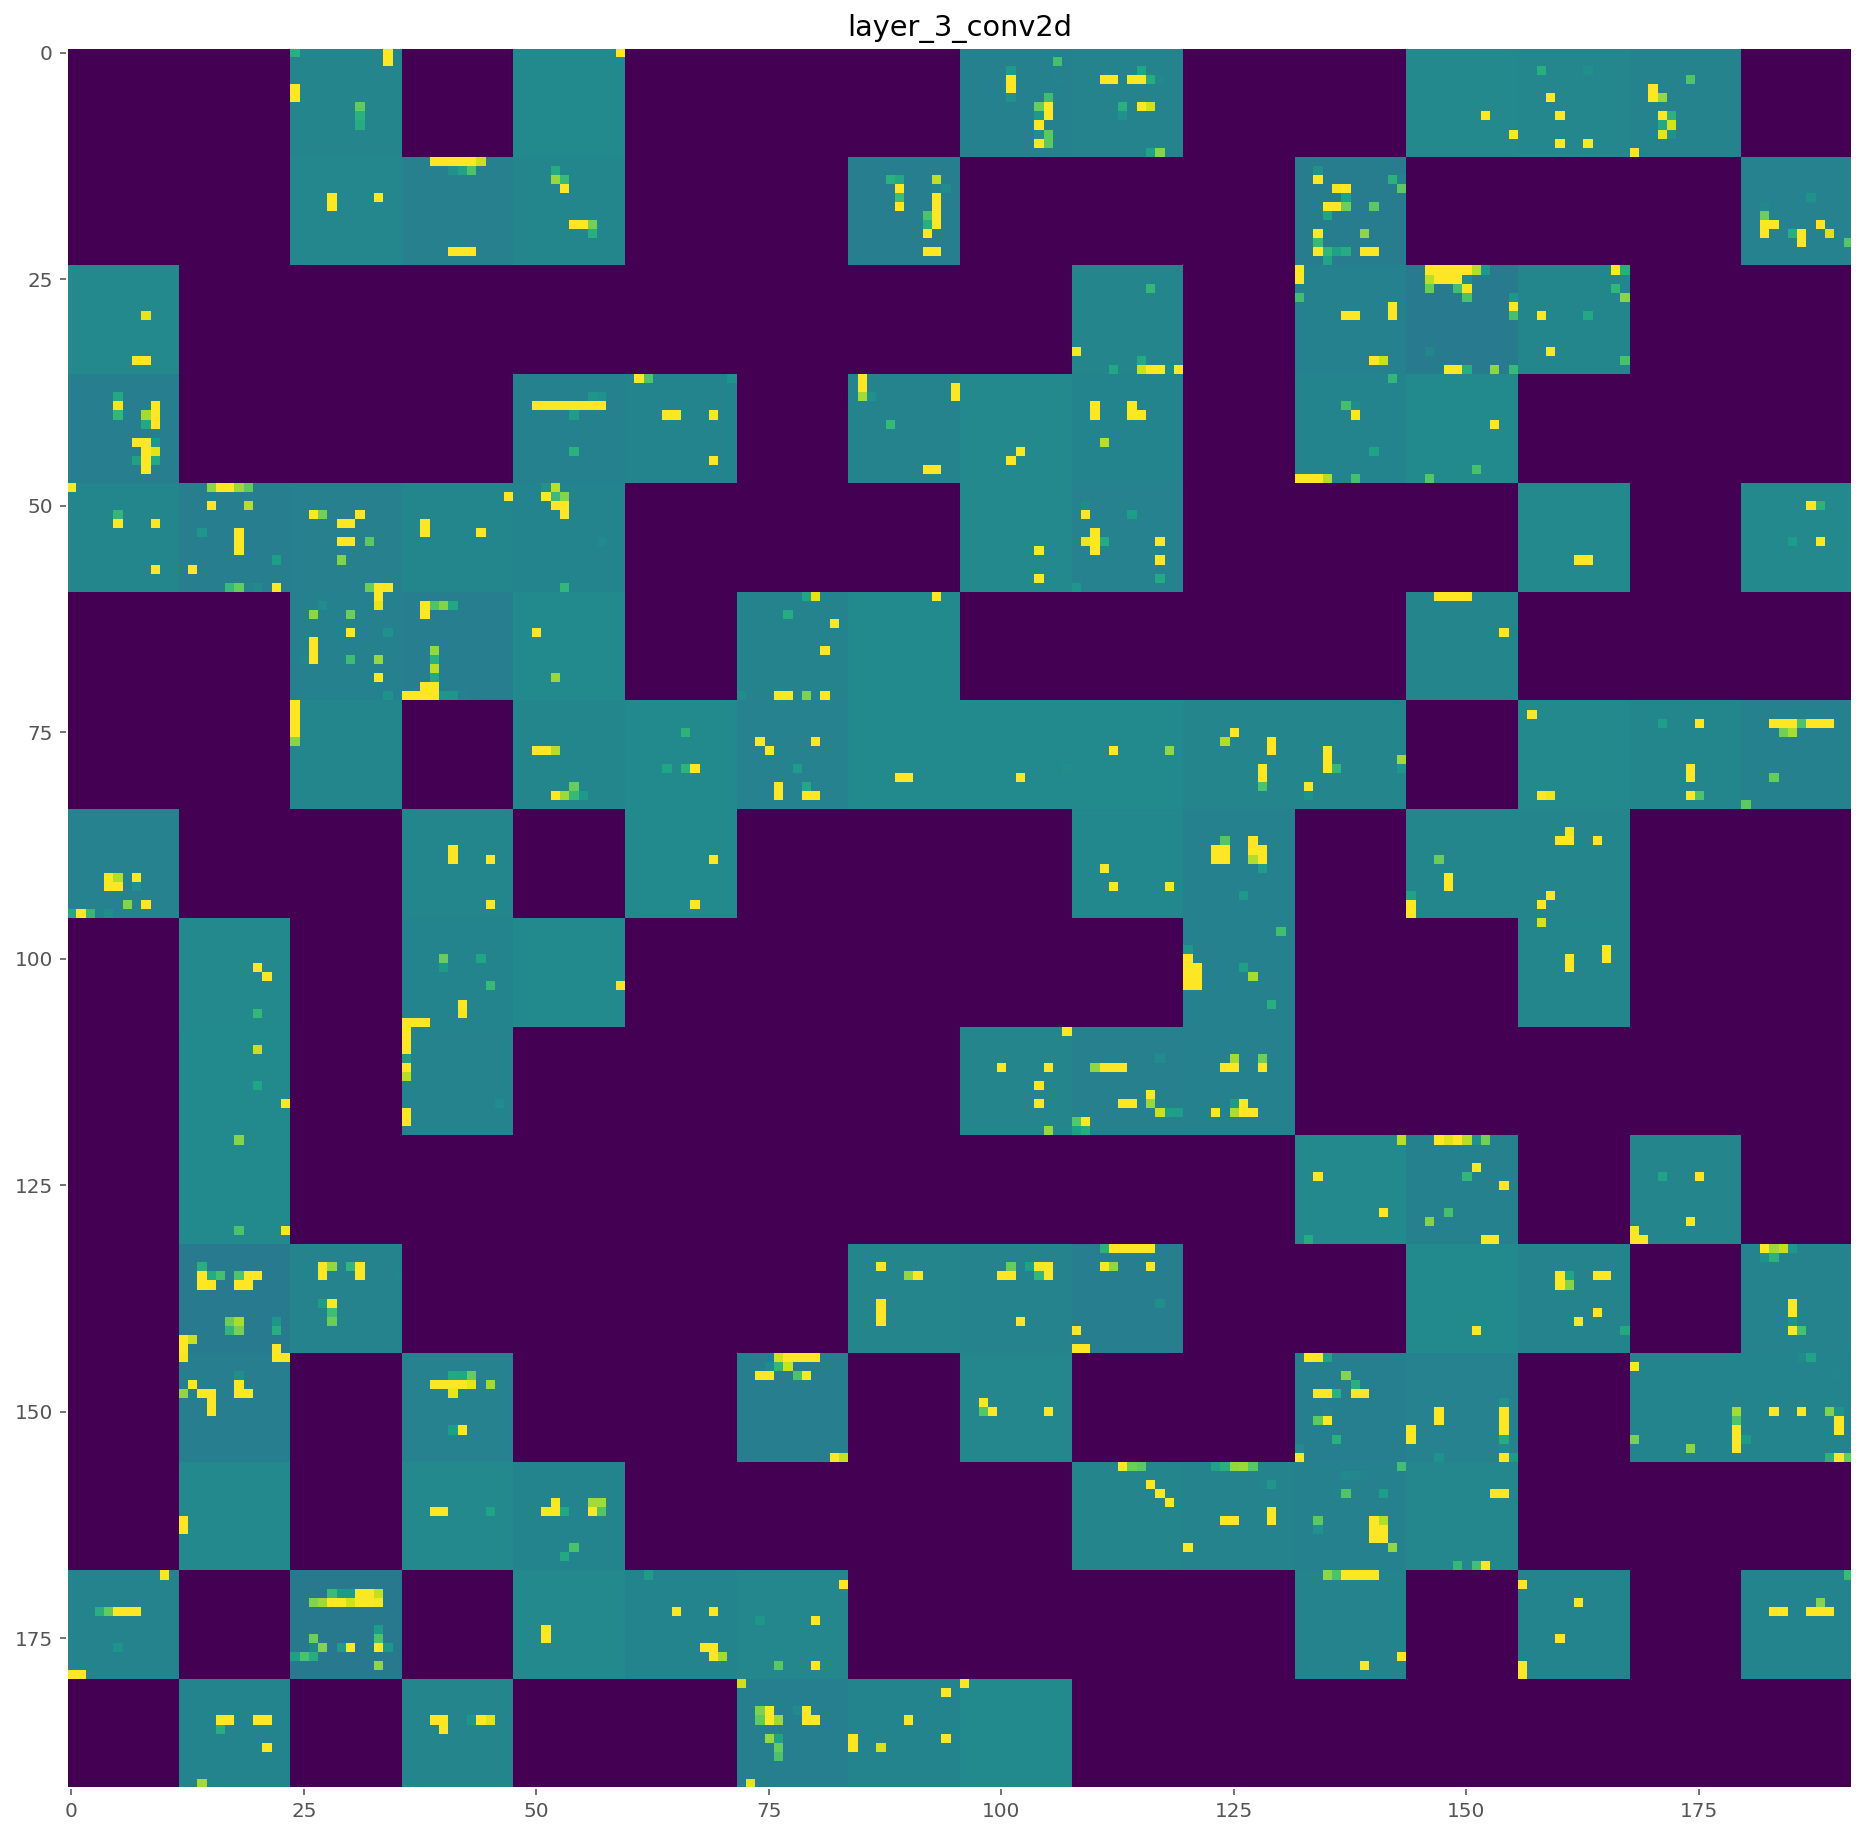

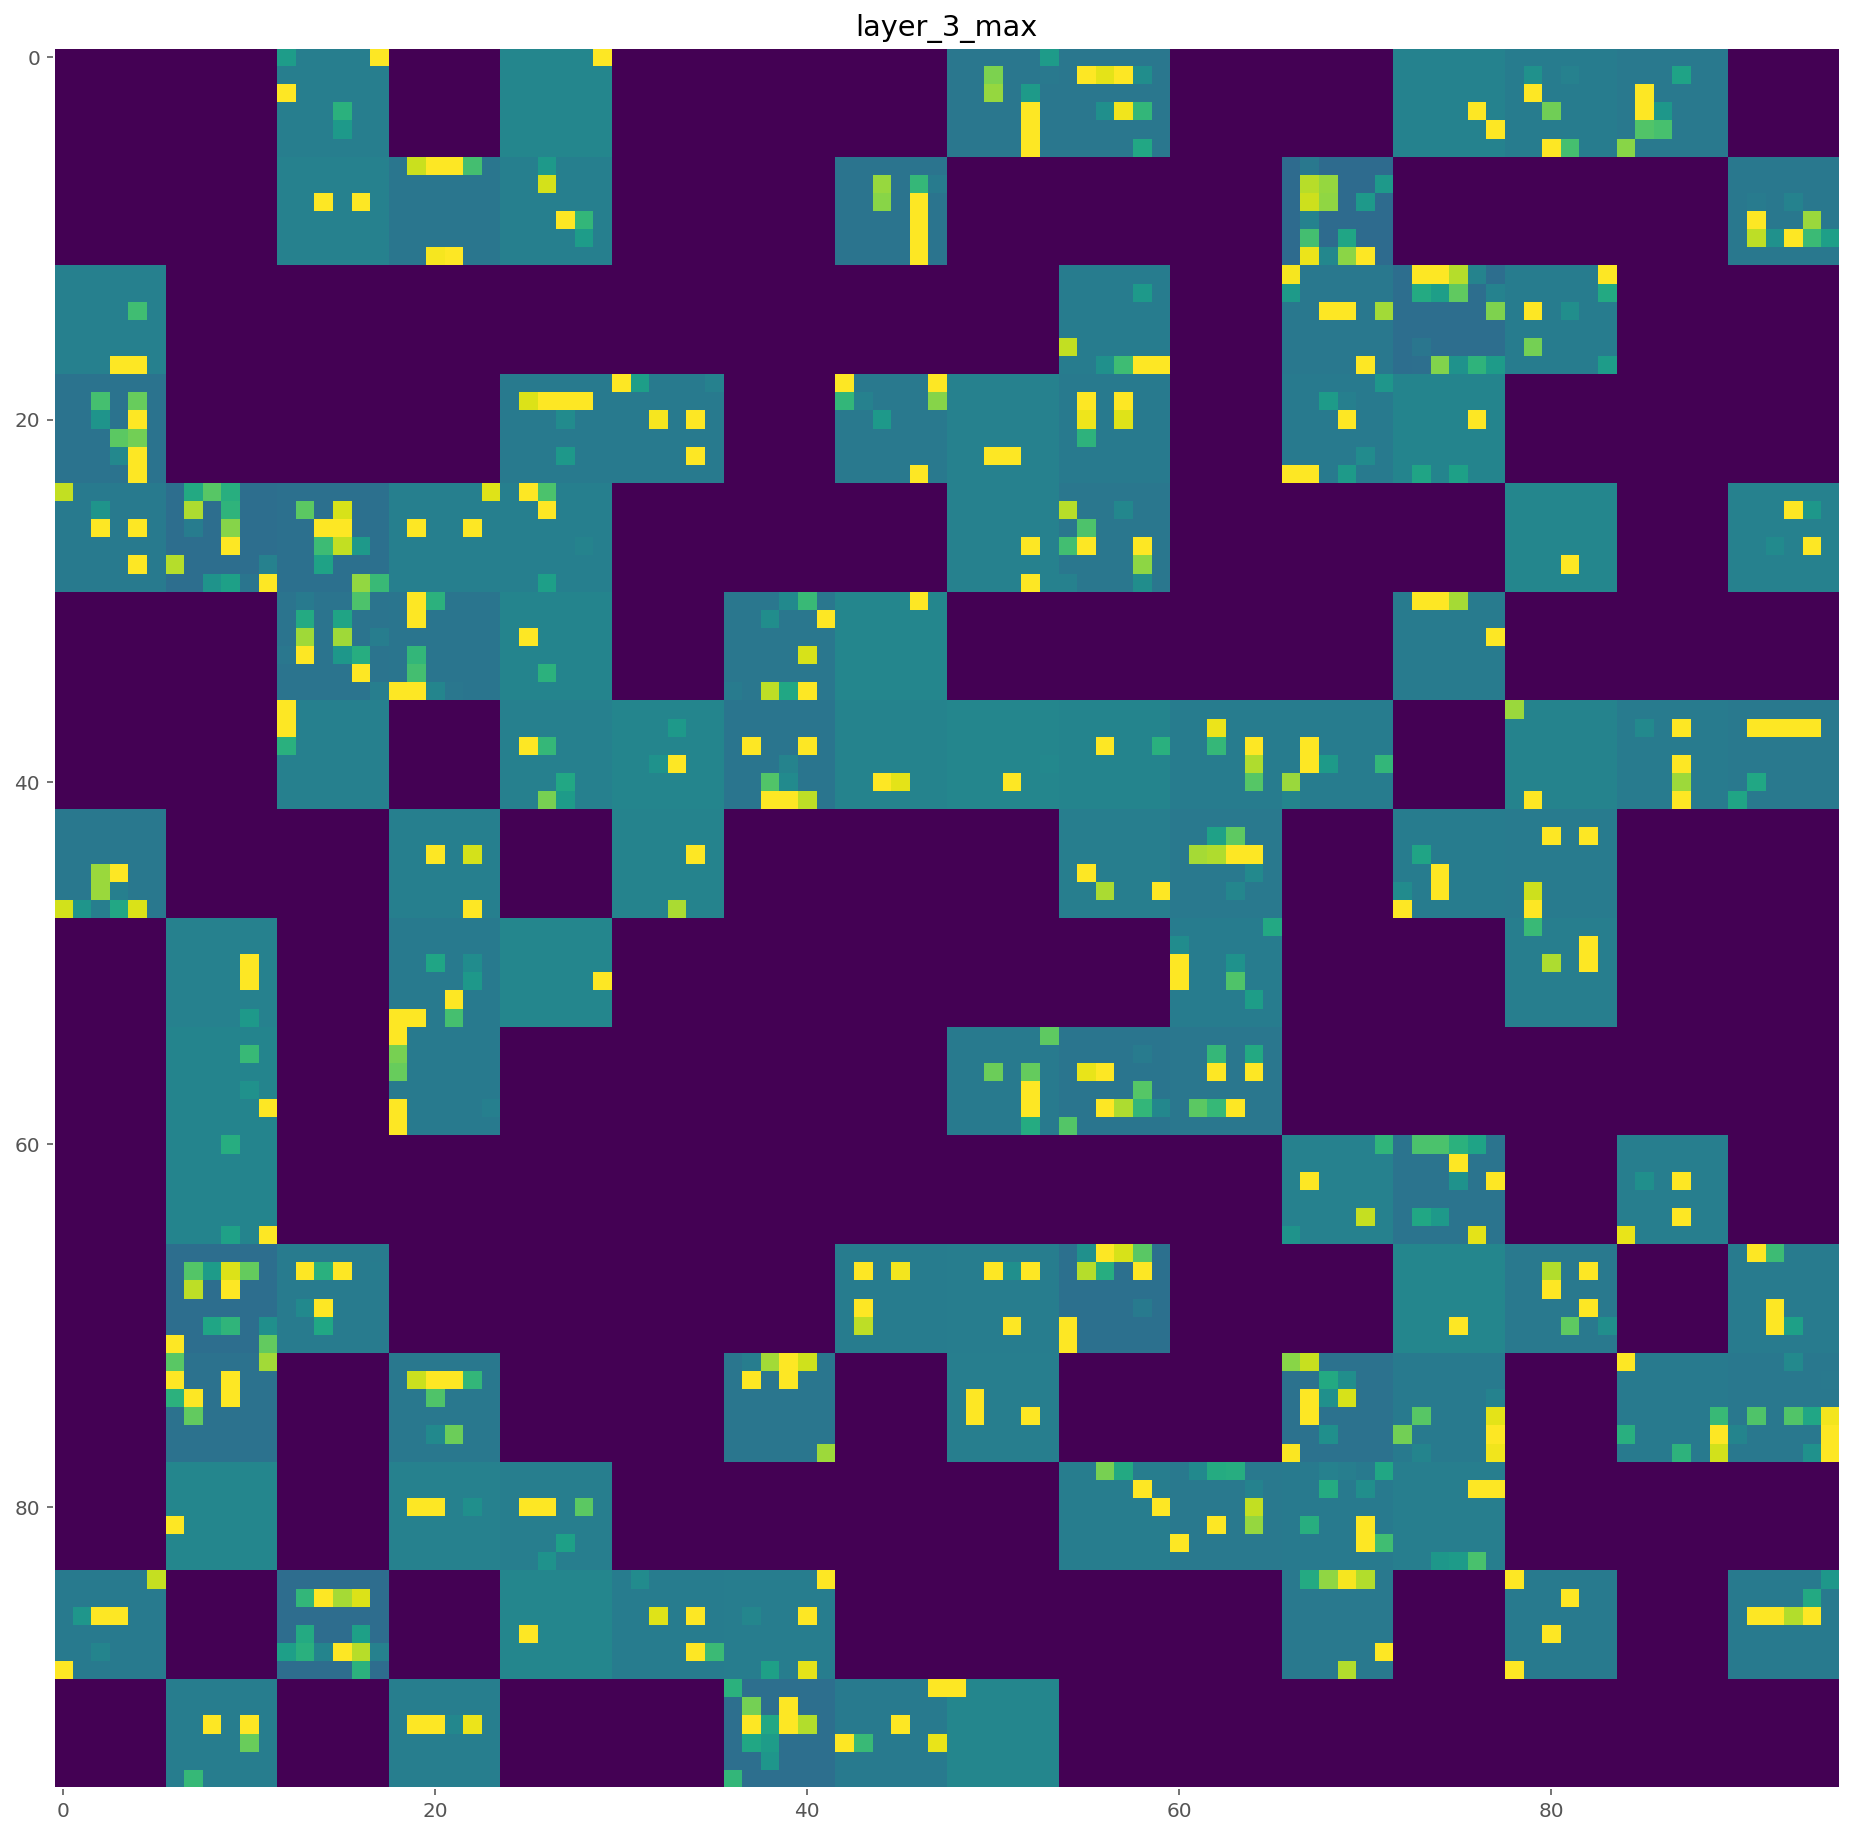

In [197]:
display_activations(angry_activations, activation_model)